In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Configuration ---
OUTPUT_DIR = "./results"  # Or your actual path
TARGET_ACCURACY_COC = 0.8

# --- Helper Function for Preprocessing ---
def preprocess_experiment_data(df, float_cols_precision=None, categorical_maps=None, verbose=True):
    """
    Preprocesses a DataFrame by converting columns, rounding floats, and mapping categoricals.

    Args:
        df (pd.DataFrame): The input DataFrame.
        float_cols_precision (dict): A dictionary mapping column names to desired rounding precision.
                                     Example: {'ADV_RATE': 1, 'discovery_quality': 1}
        categorical_maps (dict): A dictionary mapping column names to their value maps.
                                 Example: {'ATTACK_METHOD': {'single': 'Backdoor', np.nan: 'No Attack'}}
        verbose (bool): If True, print information about the preprocessing steps.

    Returns:
        pd.DataFrame: The preprocessed DataFrame.
    """
    if df.empty:
        if verbose: print("Input DataFrame is empty. Skipping preprocessing.")
        return df

    processed_df = df.copy()

    # 1. Map categorical values
    if categorical_maps:
        for col, value_map in categorical_maps.items():
            if col in processed_df.columns:
                # Handle NaN mapping first if present in keys
                if np.nan in value_map: # Check if np.nan is a key in the map
                    processed_df[col] = processed_df[col].fillna(value_map[np.nan])
                    # Remove np.nan from map so it's not processed again by .replace()
                    value_map_no_nan = {k: v for k, v in value_map.items() if not pd.isna(k)}
                    if value_map_no_nan: # If there are other mappings left
                         processed_df[col] = processed_df[col].replace(value_map_no_nan)
                else: # No specific NaN mapping, just replace
                    processed_df[col] = processed_df[col].replace(value_map)

                if verbose: print(f"Column '{col}' mapped. Unique values: {processed_df[col].unique()}")
            elif verbose: print(f"Warning: Column '{col}' for categorical mapping not found in DataFrame.")

    # 2. Convert to numeric and round specified float columns
    if float_cols_precision:
        for col, precision in float_cols_precision.items():
            if col in processed_df.columns:
                original_nan_count = processed_df[col].isna().sum()
                processed_df[col] = pd.to_numeric(processed_df[col], errors='coerce')
                coerced_nan_count = processed_df[col].isna().sum()

                if verbose and coerced_nan_count > original_nan_count:
                    print(f"Warning: Column '{col}' had {coerced_nan_count - original_nan_count} values coerced to NaN during numeric conversion.")

                # Option: Drop rows where essential numeric conversion failed for this column
                # processed_df.dropna(subset=[col], inplace=True)
                # if verbose: print(f"Dropped rows where '{col}' became NaN. Shape now: {processed_df.shape}")

                # Round AFTER potential NaN dropping
                processed_df[col] = processed_df[col].round(precision)
                if verbose: print(f"Column '{col}' converted to numeric and rounded to {precision} decimal places.")
            elif verbose: print(f"Warning: Column '{col}' for float processing not found in DataFrame.")

    # 3. Specific logic: Set ADV_RATE to 0 for 'No Attack' scenarios
    if 'ATTACK_METHOD' in processed_df.columns and 'ADV_RATE' in processed_df.columns and 'No Attack' in processed_df['ATTACK_METHOD'].unique():
        # Ensure ADV_RATE is numeric before this assignment if it wasn't in float_cols_precision
        if not pd.api.types.is_numeric_dtype(processed_df['ADV_RATE']):
            processed_df['ADV_RATE'] = pd.to_numeric(processed_df['ADV_RATE'], errors='coerce')

        processed_df.loc[processed_df['ATTACK_METHOD'] == 'No Attack', 'ADV_RATE'] = 0
        if verbose: print("Set ADV_RATE to 0 for 'No Attack' scenarios.")

    return processed_df

# --- Define Preprocessing Parameters ---
FLOAT_PRECISIONS = {
    'ADV_RATE': 1,  # Adversary rates like 0.1, 0.2, 0.3, 0.4
    'discovery_quality': 1, # Values like 0.1, 1.0, 10.0
    # Add other float columns that need controlled precision
    'FINAL_MAIN_ACC': 4, # Example: if you want to round accuracies too
    'FINAL_ASR': 4,
}

CATEGORICAL_MAPPINGS = {
    'ATTACK_METHOD': {
        'single': 'Backdoor',
        np.nan: 'No Attack' # Map actual NaN values from CSV read
        # If 'nan' (string) is in your CSV, use: 'nan': 'No Attack'
    }
    # Add other categorical mappings if needed
    # 'IS_SYBIL': {'True': 'Mimic', 'False': 'Standard'} # Example
}


# --- Load and Preprocess Data ---
try:
    summary_df_avg_raw = pd.read_csv(f"{OUTPUT_DIR}/summary_avg.csv")
    print("summary_avg.csv loaded successfully.")
    summary_df_avg = preprocess_experiment_data(
        summary_df_avg_raw,
        float_cols_precision=FLOAT_PRECISIONS,
        categorical_maps=CATEGORICAL_MAPPINGS
    )
    print(f"Processed summary_df_avg shape: {summary_df_avg.shape}")
    if not summary_df_avg.empty: display(summary_df_avg.head())
except FileNotFoundError:
    print(f"Error: summary_avg.csv not found in {OUTPUT_DIR}. Please check the path.")
    summary_df_avg = pd.DataFrame()

try:
    all_rounds_df_raw = pd.read_csv(f"{OUTPUT_DIR}/all_rounds.csv")
    print("\nall_rounds.csv loaded successfully.")
    all_rounds_df = preprocess_experiment_data(
        all_rounds_df_raw,
        float_cols_precision=FLOAT_PRECISIONS,
        categorical_maps=CATEGORICAL_MAPPINGS
    )
    print(f"Processed all_rounds_df shape: {all_rounds_df.shape}")
    if not all_rounds_df.empty: display(all_rounds_df.head())
except FileNotFoundError:
    print(f"Error: all_rounds.csv not found in {OUTPUT_DIR}. Please check the path.")
    all_rounds_df = pd.DataFrame()


# Set a consistent style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("muted")

# --- Verification (Optional but Recommended) ---
if not summary_df_avg.empty:
    print("\n--- Processed Summary Data Verification ---")
    print("Unique AGGREGATION_METHODS:", summary_df_avg['AGGREGATION_METHOD'].unique() if 'AGGREGATION_METHOD' in summary_df_avg else "N/A")
    print("Unique ATTACK_METHODS:", summary_df_avg['ATTACK_METHOD'].unique() if 'ATTACK_METHOD' in summary_df_avg else "N/A")
    print("Unique IS_SYBIL:", summary_df_avg['IS_SYBIL'].unique() if 'IS_SYBIL' in summary_df_avg else "N/A")
    print("Unique ADV_RATEs:", sorted(summary_df_avg['ADV_RATE'].unique()) if 'ADV_RATE' in summary_df_avg and not summary_df_avg['ADV_RATE'].empty else "N/A")
    print("Unique buyer_data_mode:", summary_df_avg['buyer_data_mode'].unique() if 'buyer_data_mode' in summary_df_avg else "N/A")
    print("Unique discovery_quality:", sorted(summary_df_avg['discovery_quality'].unique()) if 'discovery_quality' in summary_df_avg and not summary_df_avg['discovery_quality'].empty else "N/A")

    # Check for NaNs in key columns after processing
    print("\nNaN counts in key processed columns (summary_df_avg):")
    for col in ['ADV_RATE', 'ATTACK_METHOD', 'FINAL_MAIN_ACC', 'FINAL_ASR', 'IS_SYBIL']:
        if col in summary_df_avg.columns:
            print(f"  {col}: {summary_df_avg[col].isna().sum()}")

summary_avg.csv loaded successfully.
Column 'ATTACK_METHOD' mapped. Unique values: ['Backdoor' 'No Attack']
Column 'ADV_RATE' converted to numeric and rounded to 1 decimal places.
Column 'discovery_quality' converted to numeric and rounded to 1 decimal places.
Column 'FINAL_MAIN_ACC' converted to numeric and rounded to 4 decimal places.
Column 'FINAL_ASR' converted to numeric and rounded to 4 decimal places.
Set ADV_RATE to 0 for 'No Attack' scenarios.
Processed summary_df_avg shape: (186, 30)


,run,AGGREGATION_METHOD,DATA_SPLIT_MODE,discovery_quality,buyer_data_mode,N_CLIENTS,ATTACK_METHOD,TRIGGER_RATE,IS_SYBIL,ADV_RATE,...,AVG_UNSELECTED_DISTRIBUTION_SIMILARITY,AVG_ADVERSARY_SELECTION_RATE,AVG_BENIGN_SELECTION_RATE,AVG_COST_PER_ROUND,COST_OF_CONVERGENCE,TARGET_ACC_FOR_COC,COC_TARGET_REACHED_ROUND,PAYMENT_GINI_COEFFICIENT,TOTAL_COST,TOTAL_ROUNDS
0,2,martfl,discovery,0.1,random,30.0,Backdoor,0.1,False,0.2,...,0.998591,0.121364,0.878636,15.242015,236.333333,0.8,8.666667,0.122245,933.666667,61.666667
1,9,martfl,discovery,0.1,biased,30.0,Backdoor,0.1,False,0.2,...,0.999281,0.114330,0.885670,15.992225,293.600000,0.8,11.800000,0.142507,1140.700000,71.400000
2,3,martfl,discovery,1.0,random,30.0,Backdoor,0.1,False,0.2,...,0.892119,0.170547,0.829453,14.821181,193.000000,0.8,8.250000,0.146191,873.500000,59.000000
3,9,martfl,discovery,1.0,biased,30.0,Backdoor,0.1,False,0.2,...,0.904338,0.159976,0.840024,15.888718,233.300000,0.8,10.400000,0.120682,970.300000,61.300000
4,0,martfl,discovery,10.0,random,30.0,Backdoor,0.1,False,0.2,...,0.646567,0.433816,0.566184,12.153846,62.000000,0.8,4.000000,0.241561,316.000000,26.000000



all_rounds.csv loaded successfully.
Column 'ATTACK_METHOD' mapped. Unique values: ['Backdoor' 'No Attack']
Column 'ADV_RATE' converted to numeric and rounded to 1 decimal places.
Column 'discovery_quality' converted to numeric and rounded to 1 decimal places.
Set ADV_RATE to 0 for 'No Attack' scenarios.
Processed all_rounds_df shape: (75795, 27)


C:\Users\zeyu song\AppData\Local\Temp\ipykernel_405684\2987452016.py:116: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  all_rounds_df_raw = pd.read_csv(f"{OUTPUT_DIR}/all_rounds.csv")


,run,round,ATTACK_METHOD,TRIGGER_RATE,IS_SYBIL,ADV_RATE,CHANGE_BASE,TRIGGER_MODE,benign_rounds,trigger_mode,...,adversary_selection_rate,benign_selection_rate,cost_per_round,avg_selected_data_distribution_similarity,avg_unselected_data_distribution_similarity,main_acc,main_loss,clean_acc,triggered_acc,asr
0,0,0,Backdoor,0.1,False,0.2,True,static,0,static,...,0.200000,0.800000,30,0.998623,0.998623,0.5518,1.175421,0.5518,0.5701,0.1184
1,0,1,Backdoor,0.1,False,0.2,True,static,0,static,...,0.172414,0.827586,29,0.998641,0.998623,0.6757,0.824391,0.6757,0.6704,0.1236
2,0,2,Backdoor,0.1,False,0.2,True,static,0,static,...,0.206897,0.793103,29,0.998603,0.998623,0.7089,0.709304,0.7089,0.6917,0.1114
3,0,3,Backdoor,0.1,False,0.2,True,static,0,static,...,0.000000,1.000000,23,0.998700,0.998623,0.7316,0.654981,0.7316,0.7118,0.0949
4,0,4,Backdoor,0.1,False,0.2,True,static,0,static,...,0.206897,0.793103,29,0.998637,0.998623,0.7550,0.616033,0.7550,0.7322,0.1147


NameError: name 'selected_clients' is not defined

In [20]:
plot_data = summary_df_avg.copy()
plot_data[
        (plot_data['ATTACK_METHOD'] != 'No Attack') 
    ]

,run,AGGREGATION_METHOD,DATA_SPLIT_MODE,discovery_quality,buyer_data_mode,N_CLIENTS,ATTACK_METHOD,TRIGGER_RATE,IS_SYBIL,ADV_RATE,...,AVG_UNSELECTED_DISTRIBUTION_SIMILARITY,AVG_ADVERSARY_SELECTION_RATE,AVG_BENIGN_SELECTION_RATE,AVG_COST_PER_ROUND,COST_OF_CONVERGENCE,TARGET_ACC_FOR_COC,COC_TARGET_REACHED_ROUND,PAYMENT_GINI_COEFFICIENT,TOTAL_COST,TOTAL_ROUNDS
0,2,martfl,discovery,0.1,random,30.0,Backdoor,0.1,False,0.2,...,0.998591,0.121364,0.878636,15.242015,236.333333,0.8,8.666667,0.122245,933.666667,61.666667
1,9,martfl,discovery,0.1,biased,30.0,Backdoor,0.1,False,0.2,...,0.999281,0.114330,0.885670,15.992225,293.600000,0.8,11.800000,0.142507,1140.700000,71.400000
2,3,martfl,discovery,1.0,random,30.0,Backdoor,0.1,False,0.2,...,0.892119,0.170547,0.829453,14.821181,193.000000,0.8,8.250000,0.146191,873.500000,59.000000
3,9,martfl,discovery,1.0,biased,30.0,Backdoor,0.1,False,0.2,...,0.904338,0.159976,0.840024,15.888718,233.300000,0.8,10.400000,0.120682,970.300000,61.300000
4,0,martfl,discovery,10.0,random,30.0,Backdoor,0.1,False,0.2,...,0.646567,0.433816,0.566184,12.153846,62.000000,0.8,4.000000,0.241561,316.000000,26.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,9,martfl,discovery,0.1,biased,30.0,Backdoor,0.5,mimic,0.4,...,0.999281,0.073035,0.926965,14.503202,213.200000,0.8,11.700000,0.342433,983.400000,67.800000
86,3,martfl,discovery,1.0,random,30.0,Backdoor,0.5,mimic,0.4,...,0.892119,0.175642,0.824358,12.394784,143.250000,0.8,8.500000,0.287415,740.750000,59.750000
87,9,martfl,discovery,1.0,biased,30.0,Backdoor,0.5,mimic,0.4,...,0.904338,0.133096,0.866904,13.943873,197.300000,0.8,11.000000,0.311548,853.900000,61.200000
88,0,martfl,discovery,10.0,random,30.0,Backdoor,0.5,mimic,0.4,...,0.646567,0.007190,0.992810,7.117647,NaN,0.8,-1.000000,0.595868,242.000000,34.000000


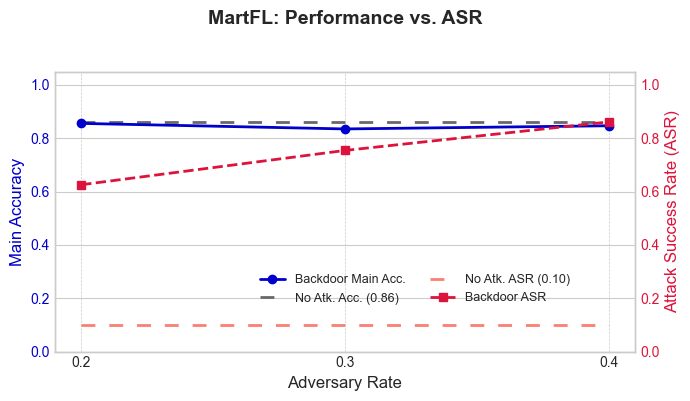

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D # For custom legend

# --- Assume summary_df_avg is loaded and your PREPROCESSING function is defined and used ---
# summary_df_avg = preprocess_experiment_data(...) # From your previous cell

if not summary_df_avg.empty:
    # --- Data Preparation ---
    plot_data = summary_df_avg.copy()
    current_aggregation_method = "MartFL" # Capitalized for title

    no_attack_perf = plot_data[plot_data['ATTACK_METHOD'] == 'No Attack'].copy()
    if not no_attack_perf.empty:
        no_attack_avg_acc = no_attack_perf['FINAL_MAIN_ACC'].mean()
        no_attack_avg_asr = 0.1 # ASR for No Attack is 0
    else:
        no_attack_avg_acc = np.nan
        no_attack_avg_asr = np.nan

    adv_rates_to_plot_on_x_for_attack = [0.2, 0.3, 0.4]
    backdoor_attack_filtered = plot_data[
        (plot_data['ATTACK_METHOD'] == 'Backdoor') &
        (plot_data['ADV_RATE'].isin(adv_rates_to_plot_on_x_for_attack))
    ].copy()

    if not backdoor_attack_filtered.empty:
        backdoor_attack_avg_perf = backdoor_attack_filtered.groupby('ADV_RATE', as_index=False)[
            ['FINAL_MAIN_ACC', 'FINAL_ASR']
        ].mean().sort_values(by='ADV_RATE')
        adv_rates_with_backdoor_data = sorted(backdoor_attack_avg_perf['ADV_RATE'].unique())
    else:
        backdoor_attack_avg_perf = pd.DataFrame(columns=['ADV_RATE', 'FINAL_MAIN_ACC', 'FINAL_ASR'])
        adv_rates_with_backdoor_data = []
        print(f"Warning: No 'Backdoor' data found for ADV_RATEs {adv_rates_to_plot_on_x_for_attack}.")

    # --- Plotting ---
    # Font sizes for paper
    TITLE_FONT_SIZE = 14
    AXIS_LABEL_FONT_SIZE = 12
    TICK_LABEL_FONT_SIZE = 10
    LEGEND_FONT_SIZE = 9
    LEGEND_TITLE_FONT_SIZE = 10
    LINE_WIDTH = 2.0 # Slightly reduced from 2.5 for typical paper figs
    MARKER_SIZE = 6   # Slightly reduced

    fig, ax1 = plt.subplots(figsize=(7, 4.5)) # Adjusted for paper

    main_acc_color_attack = 'mediumblue'
    asr_color_attack = 'crimson'
    no_attack_acc_color = 'dimgray' # Changed for better contrast with blue/red
    no_attack_asr_color = 'salmon'  # Changed for better contrast

    legend_elements = []
    x_min_for_no_attack_line = min(adv_rates_with_backdoor_data) if adv_rates_with_backdoor_data else 0.2
    x_max_for_no_attack_line = max(adv_rates_with_backdoor_data) if adv_rates_with_backdoor_data else 0.4

    # 1. Plot "No Attack" Main Accuracy
    if pd.notna(no_attack_avg_acc):
        ax1.hlines(y=no_attack_avg_acc, xmin=x_min_for_no_attack_line, xmax=x_max_for_no_attack_line,
                   color=no_attack_acc_color, linestyle=(0, (5, 5)), linewidth=LINE_WIDTH) # Dash-dot style
        legend_elements.append(Line2D([0], [0], color=no_attack_acc_color, linestyle=(0, (5,5)), lw=LINE_WIDTH, label=f'No Atk. Acc. ({no_attack_avg_acc:.2f})'))

    # 2. Plot "Backdoor" Main Accuracy
    if not backdoor_attack_avg_perf.empty:
        ax1.plot(backdoor_attack_avg_perf['ADV_RATE'], backdoor_attack_avg_perf['FINAL_MAIN_ACC'],
                 color=main_acc_color_attack, linestyle='-', marker='o',
                 linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
        legend_elements.append(Line2D([0], [0], color=main_acc_color_attack, linestyle='-', marker='o', lw=LINE_WIDTH, label='Backdoor Main Acc.'))

    ax1.set_xlabel('Adversary Rate', fontsize=AXIS_LABEL_FONT_SIZE)
    ax1.set_ylabel('Main Accuracy', color=main_acc_color_attack, fontsize=AXIS_LABEL_FONT_SIZE) # Color matches line
    ax1.tick_params(axis='y', labelcolor=main_acc_color_attack, labelsize=TICK_LABEL_FONT_SIZE)
    ax1.set_ylim(0, 1.05)
    ax1.grid(True, which='major', linestyle=':', linewidth=0.5, axis='y')

    # 3. Second y-axis for ASR
    ax2 = ax1.twinx()

    # 4. Plot "No Attack" ASR
    if pd.notna(no_attack_avg_asr):
        ax2.hlines(y=no_attack_avg_asr, xmin=x_min_for_no_attack_line, xmax=x_max_for_no_attack_line,
                   color=no_attack_asr_color, linestyle=(0, (5, 5)), linewidth=LINE_WIDTH) # Dash-dot style
        legend_elements.append(Line2D([0], [0], color=no_attack_asr_color, linestyle=(0,(5,5)), lw=LINE_WIDTH, label=f'No Atk. ASR ({no_attack_avg_asr:.2f})'))

    # 5. Plot "Backdoor" ASR
    if not backdoor_attack_avg_perf.empty:
        ax2.plot(backdoor_attack_avg_perf['ADV_RATE'], backdoor_attack_avg_perf['FINAL_ASR'],
                 color=asr_color_attack, linestyle='--', marker='s',
                 linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
        legend_elements.append(Line2D([0], [0], color=asr_color_attack, linestyle='--', marker='s', lw=LINE_WIDTH, label='Backdoor ASR'))

    ax2.set_ylabel('Attack Success Rate (ASR)', color=asr_color_attack, fontsize=AXIS_LABEL_FONT_SIZE) # Color matches line
    ax2.tick_params(axis='y', labelcolor=asr_color_attack, labelsize=TICK_LABEL_FONT_SIZE)
    ax2.set_ylim(0, 1.05)

    # 6. X-axis ticks
    if adv_rates_with_backdoor_data:
        ax1.set_xticks(ticks=adv_rates_with_backdoor_data)
        ax1.set_xticklabels(labels=[f'{r:.1f}' for r in adv_rates_with_backdoor_data], fontsize=TICK_LABEL_FONT_SIZE)
    else:
        ax1.set_xticks(ticks=[0.2,0.3,0.4]) # Fallback
        ax1.set_xticklabels(labels=['0.2','0.3','0.4'], fontsize=TICK_LABEL_FONT_SIZE)
    ax1.tick_params(axis='x', labelsize=TICK_LABEL_FONT_SIZE) # Ensure x-tick label size
    ax1.grid(True, which='major', linestyle='--', linewidth=0.5, axis='x')


    # Legend: More compact, 2 columns below plot
    if legend_elements:
        legend_elements.sort(key=lambda x: ("No Attack" not in x.get_label(), "Main Acc" not in x.get_label()))
        fig.legend(handles=legend_elements,
                   title_fontsize=LEGEND_TITLE_FONT_SIZE,
                   fontsize=LEGEND_FONT_SIZE,
                   loc='lower center', # Place below plot
                   bbox_to_anchor=(0.6, 0.3), # Adjust y for spacing below x-axis label
                   ncol=2, # Try 2 columns for 4 items
                   frameon=False) # Remove legend frame for cleaner look in paper

    fig.suptitle(f'{current_aggregation_method}: Performance vs. ASR', fontsize=TITLE_FONT_SIZE, y=0.98, fontweight='bold')
    plt.tight_layout(rect=[0, 0.1, 1, 0.95]) # Adjust rect for suptitle and bottom legend (0.1 at bottom for legend space)
    # plt.savefig(f"{current_aggregation_method}_perf_vs_asr.pdf", bbox_inches='tight') # Example save
    plt.show()

else:
    print("summary_df_avg is empty or became empty after preprocessing. Skipping Plot.")

Plotting averaged 'Backdoor' CoC. ADV_RATEs: [np.float64(0.2), np.float64(0.3), np.float64(0.4)]


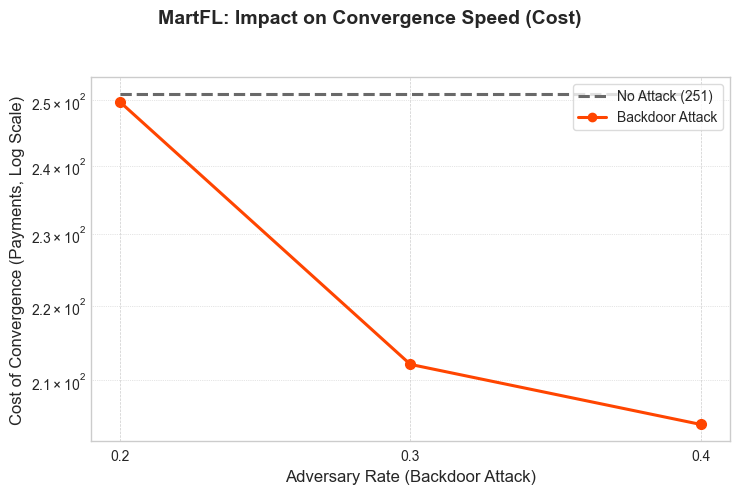

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D

# --- Assume summary_df_avg is loaded and PREPROCESSED ---
# summary_df_avg = preprocess_experiment_data(...)
# TARGET_ACCURACY_COC = 0.8 # Defined elsewhere

if not summary_df_avg.empty:
    # --- Data Preparation ---
    plot_data = summary_df_avg.copy() # Assuming it's preprocessed
    current_aggregation_method = "MartFL" # For title

    # Ensure COST_OF_CONVERGENCE_PLOT is ready (handling NaNs as per previous logic)
    if 'COST_OF_CONVERGENCE' in plot_data.columns:
        plot_data['COST_OF_CONVERGENCE'] = pd.to_numeric(plot_data['COST_OF_CONVERGENCE'], errors='coerce')
        if 'TOTAL_COST' in plot_data.columns:
            plot_data['TOTAL_COST'] = pd.to_numeric(plot_data['TOTAL_COST'], errors='coerce')
            plot_data['COST_OF_CONVERGENCE_PLOT'] = plot_data['COST_OF_CONVERGENCE'].fillna(plot_data['TOTAL_COST'])
        else:
            plot_data['COST_OF_CONVERGENCE_PLOT'] = plot_data['COST_OF_CONVERGENCE']
        if plot_data['COST_OF_CONVERGENCE_PLOT'].isna().any():
             print(f"Warning: {plot_data['COST_OF_CONVERGENCE_PLOT'].isna().sum()} NaN CoC values still present.")
    else:
        print("COST_OF_CONVERGENCE column not found. Cannot plot.")
        plot_data['COST_OF_CONVERGENCE_PLOT'] = np.nan # Ensure column exists

    # 1. "No Attack" CoC Baseline (Averaged over IS_SYBIL)
    no_attack_coc_data = plot_data[plot_data['ATTACK_METHOD'] == 'No Attack'].copy()
    if not no_attack_coc_data.empty:
        # We want a single CoC value for "No Attack" to serve as the baseline
        no_attack_baseline_coc = no_attack_coc_data['COST_OF_CONVERGENCE_PLOT'].mean()
    else:
        no_attack_baseline_coc = np.nan

    # 2. "Backdoor Attack" CoC Data, averaged over IS_SYBIL for each ADV_RATE
    adv_rates_to_plot_on_x_for_attack = [0.1, 0.2, 0.3, 0.4]
    backdoor_attack_filtered = plot_data[
        (plot_data['ATTACK_METHOD'] == 'Backdoor') &
        (plot_data['ADV_RATE'].isin(adv_rates_to_plot_on_x_for_attack))
    ].copy()

    if not backdoor_attack_filtered.empty:
        # Average CoC for "Backdoor" attack at each ADV_RATE (averaging out IS_SYBIL here)
        backdoor_avg_coc_vs_adv_rate = backdoor_attack_filtered.groupby('ADV_RATE', as_index=False)[
            'COST_OF_CONVERGENCE_PLOT'
        ].mean().sort_values(by='ADV_RATE')
        adv_rates_with_backdoor_coc_data = sorted(backdoor_avg_coc_vs_adv_rate['ADV_RATE'].unique())
        print(f"Plotting averaged 'Backdoor' CoC. ADV_RATEs: {adv_rates_with_backdoor_coc_data}")
    else:
        backdoor_avg_coc_vs_adv_rate = pd.DataFrame(columns=['ADV_RATE', 'COST_OF_CONVERGENCE_PLOT'])
        adv_rates_with_backdoor_coc_data = []
        print(f"Warning: No 'Backdoor' CoC data for ADV_RATEs {adv_rates_to_plot_on_x_for_attack}.")


    # --- Plotting ---
    TITLE_FONT_SIZE = 14
    AXIS_LABEL_FONT_SIZE = 12
    TICK_LABEL_FONT_SIZE = 10
    LEGEND_FONT_SIZE = 10 # Slightly larger legend text
    # LEGEND_TITLE_FONT_SIZE = 10 # No legend title needed for this simplified version
    LINE_WIDTH = 2.2
    MARKER_SIZE = 7

    fig, ax = plt.subplots(figsize=(7.5, 5)) # Slightly adjusted figsize

    # Colors and styles
    backdoor_coc_color = 'orangered'
    no_attack_coc_color = 'dimgray'

    legend_elements = []

    # 1. Plot "No Attack" CoC as a HORIZONTAL BASELINE LINE
    # Spanning from the first to the last ADV_RATE of the attack data
    if pd.notna(no_attack_baseline_coc) and adv_rates_with_backdoor_coc_data:
        xmin_hline = min(adv_rates_with_backdoor_coc_data)
        xmax_hline = max(adv_rates_with_backdoor_coc_data)
        ax.hlines(y=no_attack_baseline_coc,
                  xmin=xmin_hline, xmax=xmax_hline,
                  color=no_attack_coc_color,
                  linestyle='--', # Dashed line for baseline
                  linewidth=LINE_WIDTH,
                  label=f'No Attack ({no_attack_baseline_coc:.0f})') # For legend
        legend_elements.append(Line2D([0], [0], color=no_attack_coc_color, linestyle='--', lw=LINE_WIDTH, label=f'No Attack ({no_attack_baseline_coc:.0f})'))
    elif pd.notna(no_attack_baseline_coc): # If no attack data, plot as a point at x=0.1 (or another sensible default)
        ax.plot([0.1], [no_attack_baseline_coc], marker='D', markersize=MARKER_SIZE+1, color=no_attack_coc_color, linestyle='None', label=f'No Attack ({no_attack_baseline_coc:.0f})')
        legend_elements.append(Line2D([0], [0], color=no_attack_coc_color, marker='D', markersize=MARKER_SIZE+1, linestyle='None', label=f'No Attack ({no_attack_baseline_coc:.0f})'))


    # 2. Plot "Backdoor Attack" CoC (averaged over IS_SYBIL)
    if not backdoor_avg_coc_vs_adv_rate.empty:
        ax.plot(
            backdoor_avg_coc_vs_adv_rate['ADV_RATE'],
            backdoor_avg_coc_vs_adv_rate['COST_OF_CONVERGENCE_PLOT'],
            color=backdoor_coc_color,
            linestyle='-',
            marker='o',
            linewidth=LINE_WIDTH,
            markersize=MARKER_SIZE,
            label='Backdoor Attack' # For legend
        )
        legend_elements.append(Line2D([0], [0], color=backdoor_coc_color, linestyle='-', marker='o', lw=LINE_WIDTH, label='Backdoor Attack'))

    ax.set_xlabel('Adversary Rate (Backdoor Attack)', fontsize=AXIS_LABEL_FONT_SIZE)
    ax.set_ylabel(f'Cost of Convergence (Payments)', fontsize=AXIS_LABEL_FONT_SIZE)
    ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONT_SIZE, pad=6)


    # Log Scale for Y-axis (CoC)
    valid_coc_values_plot = pd.concat([
        pd.Series([no_attack_baseline_coc] if pd.notna(no_attack_baseline_coc) else []),
        backdoor_avg_coc_vs_adv_rate['COST_OF_CONVERGENCE_PLOT'] if not backdoor_avg_coc_vs_adv_rate.empty else pd.Series([])
    ]).dropna()

    if not valid_coc_values_plot.empty and (valid_coc_values_plot > 0).all():
        ax.set_yscale('log')
        ax.set_ylabel(f'Cost of Convergence (Payments, Log Scale)', fontsize=AXIS_LABEL_FONT_SIZE)
        # For log scale, ensure y-grid lines are appropriate
        ax.grid(True, which="both", ls=":", linewidth=0.5, axis='y') # Minor ticks for log
    elif not valid_coc_values_plot.empty:
        min_coc_val = valid_coc_values_plot.min()
        ax.set_ylim(bottom=max(0, min_coc_val * 0.8 if pd.notna(min_coc_val) else 0)) # Start y a bit below min
        ax.grid(True, which="major", ls=":", linewidth=0.5, axis='y')
    else:
        ax.grid(True, which="major", ls=":", linewidth=0.5, axis='y')


    # X-axis Ticks: Only show 0.1, 0.2, 0.3, 0.4
    if adv_rates_with_backdoor_coc_data:
        ax.set_xticks(ticks=adv_rates_with_backdoor_coc_data)
        ax.set_xticklabels(labels=[f'{r:.1f}' for r in adv_rates_with_backdoor_coc_data])
    elif pd.notna(no_attack_baseline_coc) : # If only no_attack_data, show a default x point
        ax.set_xticks(ticks=[0.1]) # Or a sensible single point
        ax.set_xticklabels(labels=['Baseline Ref.'])
    else: # Fallback
        ax.set_xticks(ticks=adv_rates_to_plot_on_x_for_attack)
        ax.set_xticklabels(labels=[f'{r:.1f}' for r in adv_rates_to_plot_on_x_for_attack])

    ax.grid(True, which='major', linestyle='--', linewidth=0.5, axis='x') # Grid for x-axis


    # Legend: Simple, 2 items
    if legend_elements:
        ax.legend(handles=legend_elements,
                  fontsize=LEGEND_FONT_SIZE,
                  loc='best', # Let matplotlib decide best location inside plot
                  frameon=True, edgecolor='lightgray') # Add a light frame

    fig.suptitle(f'{current_aggregation_method}: Impact on Convergence Speed (Cost)',
                 fontsize=TITLE_FONT_SIZE, y=0.98, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.94]) # Adjust for suptitle
    # plt.savefig(f"{current_aggregation_method}_coc_speed_impact.pdf", bbox_inches='tight')
    plt.show()

else:
    print("summary_df_avg is empty or became empty after preprocessing. Skipping Plot.")

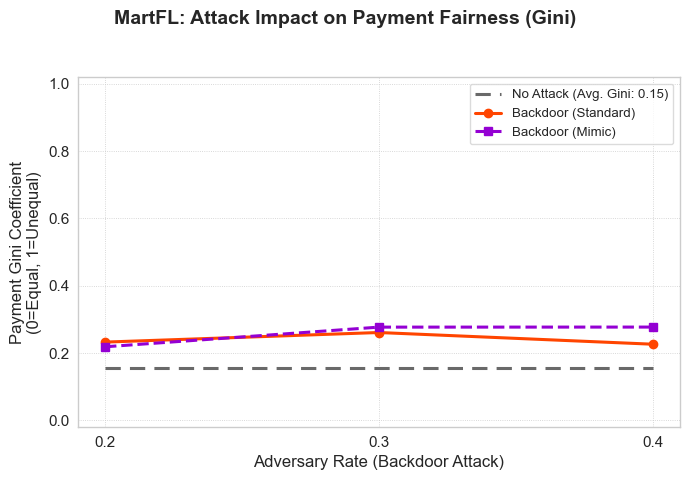

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D

# --- Assume summary_df_avg is loaded and PREPROCESSED ---
# summary_df_avg = preprocess_experiment_data(...)

if not summary_df_avg.empty:
    # --- Data Preparation ---
    plot_data = summary_df_avg.copy()
    current_aggregation_method = "MartFL"

    if 'PAYMENT_GINI_COEFFICIENT' in plot_data.columns:
        plot_data['PAYMENT_GINI_COEFFICIENT'] = pd.to_numeric(plot_data['PAYMENT_GINI_COEFFICIENT'], errors='coerce')
        plot_data.dropna(subset=['PAYMENT_GINI_COEFFICIENT'], inplace=True)
    else:
        print("PAYMENT_GINI_COEFFICIENT column not found.")
        # return or exit

    # 1. "No Attack" Gini Baseline (Averaged over ALL other variations including IS_SYBIL)
    no_attack_gini_data = plot_data[plot_data['ATTACK_METHOD'] == 'No Attack'].copy()
    if not no_attack_gini_data.empty:
        no_attack_overall_avg_gini = no_attack_gini_data['PAYMENT_GINI_COEFFICIENT'].mean()
    else:
        no_attack_overall_avg_gini = np.nan

    # 2. "Backdoor Attack" Gini Data, grouped by IS_SYBIL for each ADV_RATE
    adv_rates_to_plot_on_x_for_attack = [0.1, 0.2, 0.3, 0.4]
    backdoor_attack_filtered = plot_data[
        (plot_data['ATTACK_METHOD'] == 'Backdoor') &
        (plot_data['ADV_RATE'].isin(adv_rates_to_plot_on_x_for_attack))
    ].copy()

    if not backdoor_attack_filtered.empty:
        # Group by ADV_RATE and IS_SYBIL, then take the mean (in case of multiple runs per combo)
        # This effectively gives us one line per IS_SYBIL state for the backdoor attack
        backdoor_gini_by_sybil_adv_rate = backdoor_attack_filtered.groupby(
            ['ADV_RATE', 'IS_SYBIL'], as_index=False
        )['PAYMENT_GINI_COEFFICIENT'].mean().sort_values(by=['IS_SYBIL', 'ADV_RATE'])
        
        adv_rates_with_backdoor_gini_data = sorted(backdoor_gini_by_sybil_adv_rate['ADV_RATE'].unique())
    else:
        backdoor_gini_by_sybil_adv_rate = pd.DataFrame(columns=['ADV_RATE', 'IS_SYBIL', 'PAYMENT_GINI_COEFFICIENT'])
        adv_rates_with_backdoor_gini_data = []
        print(f"Warning: No 'Backdoor' Gini data for ADV_RATEs {adv_rates_to_plot_on_x_for_attack}.")

    # --- Plotting ---
    TITLE_FONT_SIZE = 14; AXIS_LABEL_FONT_SIZE = 12; TICK_LABEL_FONT_SIZE = 11
    LEGEND_FONT_SIZE = 9.5 # Adjusted for 3 items
    LINE_WIDTH = 2.2
    MARKER_SIZE = 6

    fig, ax = plt.subplots(figsize=(7, 4.8)) # Slightly taller for legend if needed

    # Define colors and styles
    no_attack_color = 'dimgray'
    backdoor_sybil_false_color = 'orangered' # Standard Backdoor
    backdoor_sybil_mimic_color = 'darkviolet'  # Mimic Backdoor

    backdoor_sybil_false_style = '-'
    backdoor_sybil_mimic_style = '--'

    backdoor_sybil_false_marker = 'o'
    backdoor_sybil_mimic_marker = 's'

    legend_elements = []

    # Determine x-range for horizontal "No Attack" line
    xmin_hline = min(adv_rates_with_backdoor_gini_data) if adv_rates_with_backdoor_gini_data else 0.1
    xmax_hline = max(adv_rates_with_backdoor_gini_data) if adv_rates_with_backdoor_gini_data else 0.4

    # 1. Plot "No Attack" Gini as a single HORIZONTAL BASELINE LINE
    if pd.notna(no_attack_overall_avg_gini):
        ax.hlines(y=no_attack_overall_avg_gini, xmin=xmin_hline, xmax=xmax_hline,
                  color=no_attack_color,
                  linestyle=(0, (5,3)), # Loosely dotted
                  linewidth=LINE_WIDTH)
        legend_elements.append(Line2D([0], [0], color=no_attack_color, linestyle=(0,(5,3)), lw=LINE_WIDTH,
                                      label=f'No Attack (Avg. Gini: {no_attack_overall_avg_gini:.2f})'))

    # 2. Plot "Backdoor Attack" Gini, splitting lines by IS_SYBIL
    if not backdoor_gini_by_sybil_adv_rate.empty:
        # Plot for IS_SYBIL = 'False' (Standard Backdoor)
        data_sybil_false = backdoor_gini_by_sybil_adv_rate[backdoor_gini_by_sybil_adv_rate['IS_SYBIL'] == 'False']
        if not data_sybil_false.empty:
            ax.plot(data_sybil_false['ADV_RATE'], data_sybil_false['PAYMENT_GINI_COEFFICIENT'],
                    color=backdoor_sybil_false_color,
                    linestyle=backdoor_sybil_false_style,
                    marker=backdoor_sybil_false_marker,
                    linewidth=LINE_WIDTH,
                    markersize=MARKER_SIZE)
            legend_elements.append(Line2D([0], [0], color=backdoor_sybil_false_color,
                                          linestyle=backdoor_sybil_false_style, marker=backdoor_sybil_false_marker,
                                          markerfacecolor=backdoor_sybil_false_color, markersize=MARKER_SIZE,
                                          lw=LINE_WIDTH, label='Backdoor (Standard)'))

        # Plot for IS_SYBIL = 'mimic'
        data_sybil_mimic = backdoor_gini_by_sybil_adv_rate[backdoor_gini_by_sybil_adv_rate['IS_SYBIL'] == 'mimic']
        if not data_sybil_mimic.empty:
            ax.plot(data_sybil_mimic['ADV_RATE'], data_sybil_mimic['PAYMENT_GINI_COEFFICIENT'],
                    color=backdoor_sybil_mimic_color,
                    linestyle=backdoor_sybil_mimic_style,
                    marker=backdoor_sybil_mimic_marker,
                    linewidth=LINE_WIDTH,
                    markersize=MARKER_SIZE)
            legend_elements.append(Line2D([0], [0], color=backdoor_sybil_mimic_color,
                                          linestyle=backdoor_sybil_mimic_style, marker=backdoor_sybil_mimic_marker,
                                          markerfacecolor=backdoor_sybil_mimic_color, markersize=MARKER_SIZE,
                                          lw=LINE_WIDTH, label='Backdoor (Mimic)'))


    ax.set_xlabel('Adversary Rate (Backdoor Attack)', fontsize=AXIS_LABEL_FONT_SIZE)
    ax.set_ylabel('Payment Gini Coefficient\n(0=Equal, 1=Unequal)', fontsize=AXIS_LABEL_FONT_SIZE)
    ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONT_SIZE, pad=6)
    ax.set_ylim(-0.02, 1.02)

    # X-axis Ticks
    if adv_rates_with_backdoor_gini_data:
        ax.set_xticks(ticks=adv_rates_with_backdoor_gini_data)
        ax.set_xticklabels(labels=[f'{r:.1f}' for r in adv_rates_with_backdoor_gini_data])
    else:
        ax.set_xticks(ticks=adv_rates_to_plot_on_x_for_attack)
        ax.set_xticklabels(labels=[f'{r:.1f}' for r in adv_rates_to_plot_on_x_for_attack])

    ax.grid(True, which='major', linestyle=':', linewidth=0.6)

    # Legend: 3 items, can be single column or adjusted
    if legend_elements:
        ax.legend(handles=legend_elements,
                  fontsize=LEGEND_FONT_SIZE,
                  loc='best',
                  frameon=True, edgecolor='lightgray')

    fig.suptitle(f'{current_aggregation_method}: Attack Impact on Payment Fairness (Gini)',
                 fontsize=TITLE_FONT_SIZE, y=0.99, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # plt.savefig(f"{current_aggregation_method}_gini_sybil_contrast.pdf", bbox_inches='tight')
    plt.show()

else:
    print("summary_df_avg is empty or became empty after preprocessing. Skipping Plot.")

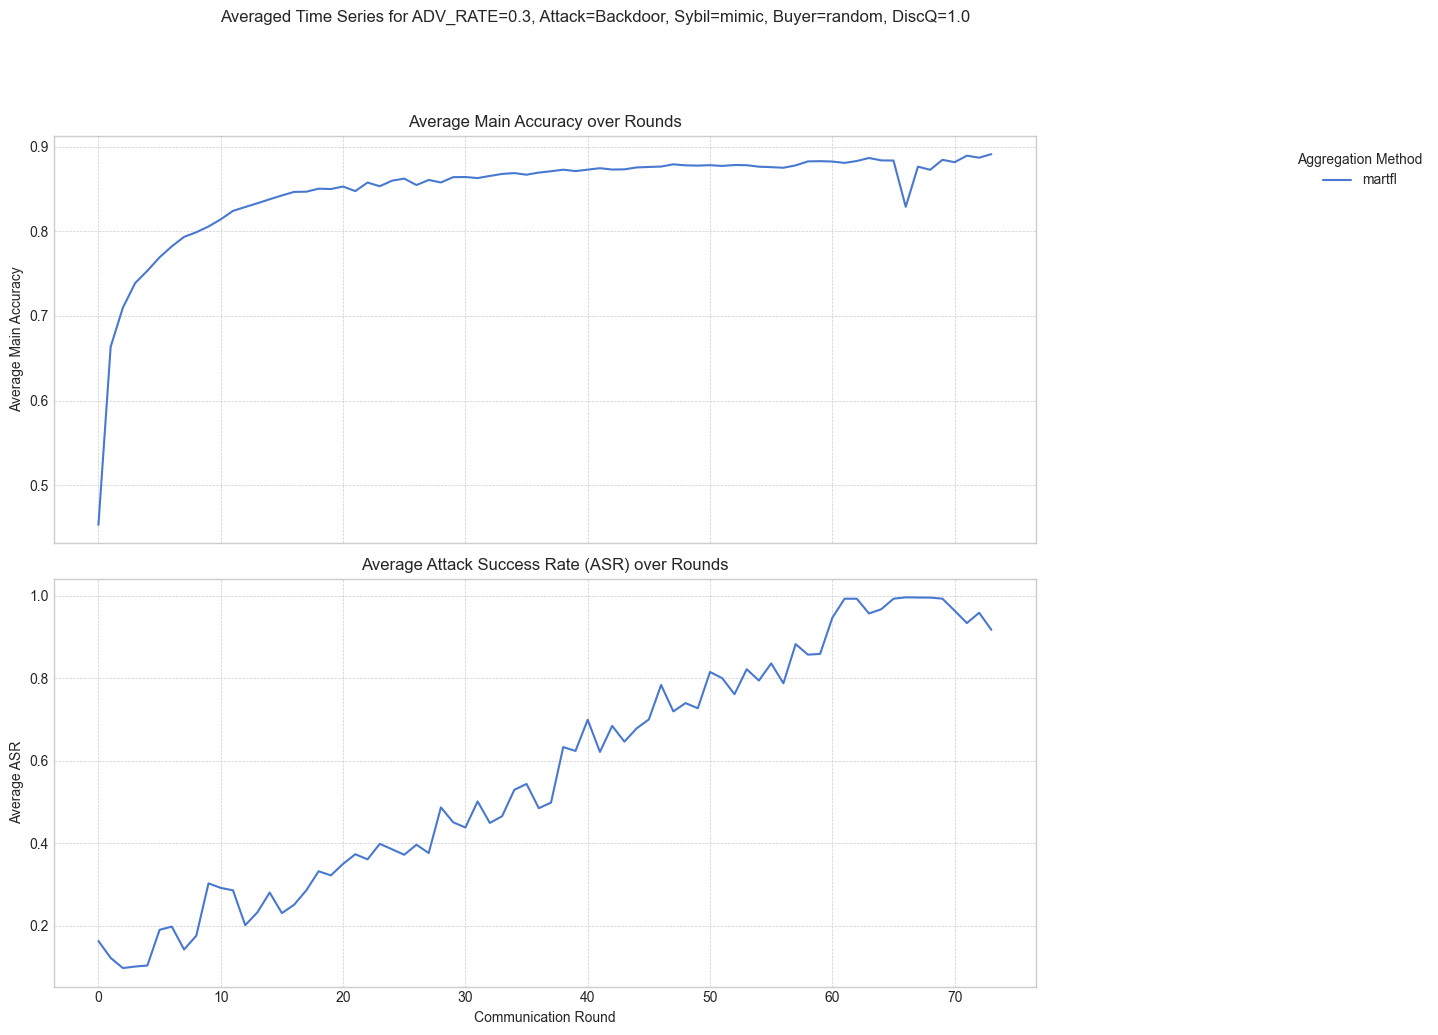

In [47]:
# Cell 8: Plot 6 - Time Series: AVERAGE Accuracy and ASR over Rounds (from all_rounds.csv)

if not all_rounds_df.empty:
    # --- Select a FEW specific experiment configurations to plot time series ---
    # Define the parameters that constitute a unique experiment configuration for averaging
    CONFIG_ADV_RATE = 0.3
    CONFIG_ATTACK_METHOD = 'Backdoor'
    CONFIG_IS_SYBIL = 'mimic'
    CONFIG_BUYER_MODE = 'random'
    CONFIG_DISCOVERY_QUALITY = 1.0    
    # CONFIG_DATASET = 'FMNIST' # Add if you have this column and want to filter by it

    # Filter for the base configuration
    base_time_series_df = all_rounds_df[
        (all_rounds_df['ADV_RATE'] == CONFIG_ADV_RATE) &
        (all_rounds_df['ATTACK_METHOD'] == CONFIG_ATTACK_METHOD) &
        (all_rounds_df['IS_SYBIL'] == CONFIG_IS_SYBIL) &
        (all_rounds_df['buyer_data_mode'] == CONFIG_BUYER_MODE) &
        (all_rounds_df['discovery_quality'] == CONFIG_DISCOVERY_QUALITY)
        # Add (all_rounds_df['dataset_name'] == CONFIG_DATASET) if needed
    ].copy()

    if not base_time_series_df.empty:
        # Group by the varying parameter (e.g., AGGREGATION_METHOD) and 'round', then average
        # Add other identifying columns to groupby if they also define a unique setup for comparison
        # For example, if 'AGGREGATION_METHOD' and 'TRIGGER_MODE' vary for this specific plot.
        # Here, we assume we are comparing different 'AGGREGATION_METHOD's.
        grouping_cols = ['AGGREGATION_METHOD', 'round']
        
        # If you have other parameters that vary within this slice, add them to grouping_cols
        # e.g., if 'CHANGE_BASE' also varies for MartFL under these conditions:
        # if 'CHANGE_BASE' in base_time_series_df.columns:
        #    grouping_cols.insert(1, 'CHANGE_BASE') # Insert before 'round'

        averaged_time_series_df = base_time_series_df.groupby(grouping_cols, as_index=False)[
            ['main_acc', 'asr', 'cost_per_round'] # Add other metrics you want averaged over time
        ].mean() # Use .median() if outliers are a concern

        if not averaged_time_series_df.empty:
            fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True) # Make it 3,1 if plotting cost_per_round

            # Plot Main Accuracy over rounds
            sns.lineplot(data=averaged_time_series_df, x='round', y='main_acc', hue='AGGREGATION_METHOD', ax=axes[0], legend='full', errorbar=('ci', 95))
            axes[0].set_title(f'Average Main Accuracy over Rounds')
            axes[0].set_ylabel('Average Main Accuracy')
            axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)

            # Plot ASR over rounds (only if an attack is present)
            if CONFIG_ATTACK_METHOD != 'None':
                sns.lineplot(data=averaged_time_series_df, x='round', y='asr', hue='AGGREGATION_METHOD', ax=axes[1], legend=False, errorbar=('ci', 95))
                axes[1].set_title(f'Average Attack Success Rate (ASR) over Rounds')
                axes[1].set_ylabel('Average ASR')
            else:
                axes[1].set_title('ASR (No Attack Scenario)')
                axes[1].text(0.5, 0.5, 'No Attack', horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes)
            
            axes[1].set_xlabel('Communication Round')
            axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)

            # Optional: Plot Average Cost per Round
            # sns.lineplot(data=averaged_time_series_df, x='round', y='cost_per_round', hue='AGGREGATION_METHOD', ax=axes[2], legend=False)
            # axes[2].set_title(f'Average Cost Per Round')
            # axes[2].set_ylabel('Average Cost')
            # axes[2].set_xlabel('Communication Round')
            # axes[2].grid(True, which='both', linestyle='--', linewidth=0.5)
            
            # Consolidate legends
            handles, labels = axes[0].get_legend_handles_labels()
            fig.legend(handles, labels, title='Aggregation Method', loc='upper right', bbox_to_anchor=(1.2, 0.9)) # Adjusted bbox
            axes[0].get_legend().remove()

            plt.suptitle(f'Averaged Time Series for ADV_RATE={CONFIG_ADV_RATE}, Attack={CONFIG_ATTACK_METHOD}, Sybil={CONFIG_IS_SYBIL}, Buyer={CONFIG_BUYER_MODE}, DiscQ={CONFIG_DISCOVERY_QUALITY}', y=1.03)
            plt.tight_layout(rect=[0, 0, 0.88, 0.97]) # Adjust rect for legend
            plt.show()
        else:
            print("Averaged time series data is empty after grouping. Check grouping columns and filters.")
    else:
        print(f"No data found for the specific time series scenario in Plot 6 (ADV_RATE={CONFIG_ADV_RATE}, etc.). Adjust filters.")
else:
    print("all_rounds_df is empty. Skipping Plot 6.")

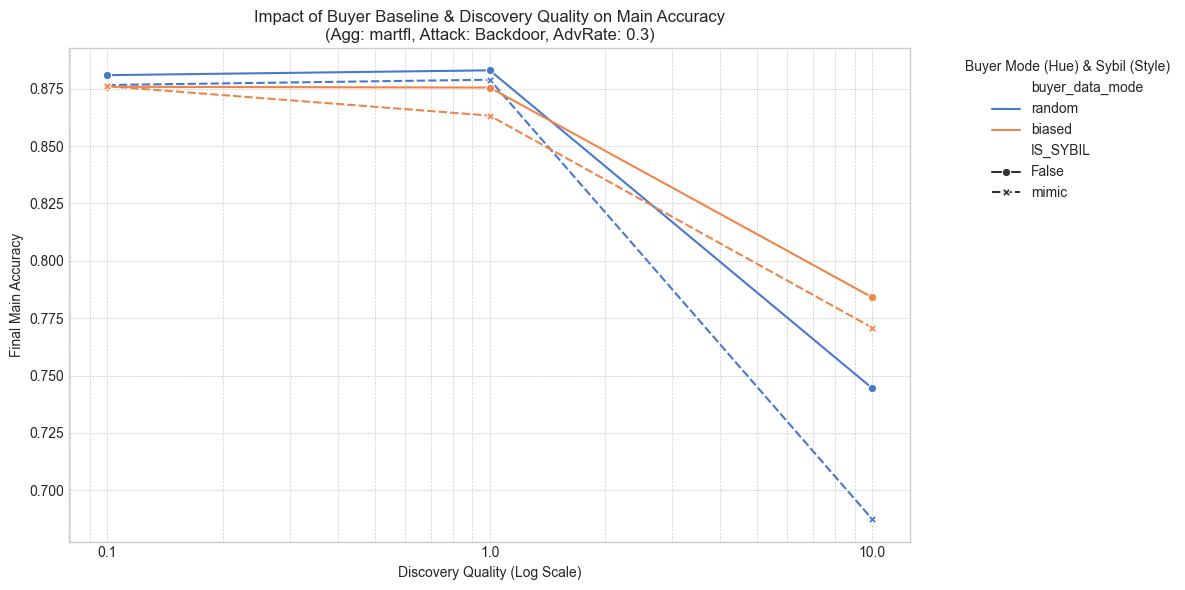

In [49]:
if not summary_df_avg.empty:
    # --- Select a specific aggregation and attack scenario ---
    AGG_METHOD_TO_ANALYZE = 'martfl' # or 'fltrust', 'fedavg'
    ATTACK_TO_ANALYZE = 'Backdoor' # or 'None'
    ADV_RATE_TO_ANALYZE = 0.3

    focus_df = summary_df_avg[
        (summary_df_avg['AGGREGATION_METHOD'] == AGG_METHOD_TO_ANALYZE) &
        (summary_df_avg['ATTACK_METHOD'] == ATTACK_TO_ANALYZE) &
        (summary_df_avg['ADV_RATE'] == ADV_RATE_TO_ANALYZE)
    ].copy()

    if not focus_df.empty:
        # Ensure discovery_quality is numeric for proper sorting/plotting if it's read as string
        focus_df['discovery_quality'] = pd.to_numeric(focus_df['discovery_quality'], errors='coerce')
        focus_df.dropna(subset=['discovery_quality'], inplace=True)


        plt.figure(figsize=(12, 6))
        sns.lineplot(
            data=focus_df,
            x='discovery_quality',
            y='FINAL_MAIN_ACC',
            hue='buyer_data_mode', # How buyer's baseline affects things
            style='IS_SYBIL',      # How sybil/mimic interacts
            markers=True,
            errorbar=('ci', 95) if 'FINAL_MAIN_ACC_STD' in focus_df.columns else None
        )
        plt.xscale('log') # Discovery quality might be on a log scale (0.1, 1.0, 10.0)
        plt.title(f'Impact of Buyer Baseline & Discovery Quality on Main Accuracy\n(Agg: {AGG_METHOD_TO_ANALYZE}, Attack: {ATTACK_TO_ANALYZE}, AdvRate: {ADV_RATE_TO_ANALYZE})')
        plt.xlabel('Discovery Quality (Log Scale)')
        plt.ylabel('Final Main Accuracy')
        plt.xticks(focus_df['discovery_quality'].unique(), labels=focus_df['discovery_quality'].unique()) # Show actual values
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)
        plt.legend(title='Buyer Mode (Hue) & Sybil (Style)', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()
    else:
        print(f"No data found for the specific scenario in Plot 7 (Agg: {AGG_METHOD_TO_ANALYZE}, etc.). Adjust filters.")
else:
    print("summary_df_avg is empty. Skipping Plot 7.")

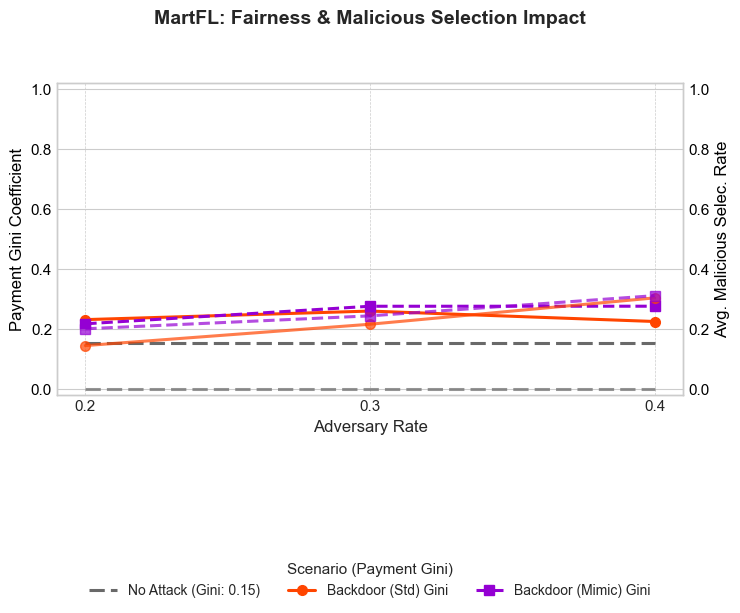

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D

# --- Assume summary_df_avg is loaded and PREPROCESSED from a PREVIOUS cell ---
# Example: summary_df_avg = preprocess_experiment_data(...)

if 'summary_df_avg' in locals() and not summary_df_avg.empty:
    # --- Data Preparation specific to this plot ---
    plot_data_focus = summary_df_avg.copy()
    current_aggregation_method = "MartFL"

    # 1. "No Attack" Baseline (Overall Average)
    no_attack_data = plot_data_focus[plot_data_focus['ATTACK_METHOD'] == 'No Attack'].copy()
    no_attack_avg_gini = no_attack_data['PAYMENT_GINI_COEFFICIENT'].mean() if not no_attack_data.empty else np.nan
    no_attack_avg_mal_select_rate = 0.0 # By definition for no attack

    # 2. "Backdoor Attack" Data, distinguishing IS_SYBIL
    adv_rates_to_plot_on_x = [0.1, 0.2, 0.3, 0.4]
    backdoor_attack_data = plot_data_focus[
        (plot_data_focus['ATTACK_METHOD'] == 'Backdoor') &
        (plot_data_focus['ADV_RATE'].isin(adv_rates_to_plot_on_x))
    ].copy()

    # Prepare grouped data for backdoor attack lines
    if not backdoor_attack_data.empty:
        # We need Gini and Malicious Selection Rate for each IS_SYBIL type at each ADV_RATE
        backdoor_perf_by_sybil = backdoor_attack_data.groupby(['ADV_RATE', 'IS_SYBIL'], as_index=False).agg(
            AVG_GINI=('PAYMENT_GINI_COEFFICIENT', 'mean'),
            AVG_MAL_SELECT_RATE=('AVG_ADVERSARY_SELECTION_RATE', 'mean')
        ).sort_values(by=['IS_SYBIL', 'ADV_RATE'])
        adv_rates_present_in_backdoor_data = sorted(backdoor_perf_by_sybil['ADV_RATE'].unique())
    else:
        print(f"Warning: No 'Backdoor' data for Gini/Selection plot for ADV_RATEs {adv_rates_to_plot_on_x}.")
        backdoor_perf_by_sybil = pd.DataFrame()
        adv_rates_present_in_backdoor_data = []

    # --- Plotting ---
    TITLE_FONT_SIZE = 14; AXIS_LABEL_FONT_SIZE = 12; TICK_LABEL_FONT_SIZE = 11
    LEGEND_FONT_SIZE = 10; LEGEND_TITLE_FONT_SIZE = 11
    LINE_WIDTH = 2.2; MARKER_SIZE = 7

    fig, ax1 = plt.subplots(figsize=(7.5, 5.0)) # ax1 for Gini Coefficient

    # Define visual properties for the 3 main conditions
    colors = {
        'No Attack': 'dimgray',
        'Backdoor (Standard)': 'orangered', # IS_SYBIL = False
        'Backdoor (Mimic)': 'darkviolet'    # IS_SYBIL = mimic
    }
    linestyles = {
        'No Attack': (0, (5, 2)),       # Loosely dotted baseline
        'Backdoor (Standard)': '-',     # Solid
        'Backdoor (Mimic)': '--'        # Dashed
    }
    markers = { # Only for backdoor lines, baseline is hline
        'Backdoor (Standard)': 'o',
        'Backdoor (Mimic)': 's'
    }
    legend_elements = []
    xmin_hline = min(adv_rates_present_in_backdoor_data) if adv_rates_present_in_backdoor_data else 0.1
    xmax_hline = max(adv_rates_present_in_backdoor_data) if adv_rates_present_in_backdoor_data else 0.4

    # --- Plot Gini Coefficient (ax1) ---
    # 1a. "No Attack" Gini Baseline (one line)
    if pd.notna(no_attack_avg_gini):
        ax1.hlines(y=no_attack_avg_gini, xmin=xmin_hline, xmax=xmax_hline,
                   color=colors['No Attack'], linestyle=linestyles['No Attack'], linewidth=LINE_WIDTH)
        legend_elements.append(Line2D([0], [0], color=colors['No Attack'], linestyle=linestyles['No Attack'],
                                      lw=LINE_WIDTH, label=f'No Attack (Gini: {no_attack_avg_gini:.2f})'))

    # 1b. "Backdoor Attack" Gini (two lines: Standard and Mimic)
    if not backdoor_perf_by_sybil.empty:
        # Standard Backdoor (IS_SYBIL == 'False')
        data_std_backdoor = backdoor_perf_by_sybil[backdoor_perf_by_sybil['IS_SYBIL'] == 'False']
        if not data_std_backdoor.empty:
            ax1.plot(data_std_backdoor['ADV_RATE'], data_std_backdoor['AVG_GINI'],
                     color=colors['Backdoor (Standard)'], linestyle=linestyles['Backdoor (Standard)'],
                     marker=markers['Backdoor (Standard)'], linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
            legend_elements.append(Line2D([0], [0], color=colors['Backdoor (Standard)'], linestyle=linestyles['Backdoor (Standard)'],
                                          marker=markers['Backdoor (Standard)'], markersize=MARKER_SIZE, lw=LINE_WIDTH,
                                          label='Backdoor Gini (Std)'))
        # Mimic Backdoor (IS_SYBIL == 'mimic')
        data_mimic_backdoor = backdoor_perf_by_sybil[backdoor_perf_by_sybil['IS_SYBIL'] == 'mimic']
        if not data_mimic_backdoor.empty:
            ax1.plot(data_mimic_backdoor['ADV_RATE'], data_mimic_backdoor['AVG_GINI'],
                     color=colors['Backdoor (Mimic)'], linestyle=linestyles['Backdoor (Mimic)'],
                     marker=markers['Backdoor (Mimic)'], linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
            legend_elements.append(Line2D([0], [0], color=colors['Backdoor (Mimic)'], linestyle=linestyles['Backdoor (Mimic)'],
                                          marker=markers['Backdoor (Mimic)'], markersize=MARKER_SIZE, lw=LINE_WIDTH,
                                          label='Backdoor Gini (Mimic)'))

    ax1.set_xlabel('Adversary Rate', fontsize=AXIS_LABEL_FONT_SIZE)
    ax1.set_ylabel('Payment Gini Coefficient', color='black', fontsize=AXIS_LABEL_FONT_SIZE)
    ax1.tick_params(axis='y', labelcolor='black', labelsize=TICK_LABEL_FONT_SIZE)
    ax1.set_ylim(-0.02, 1.02)
    ax1.grid(True, which='major', linestyle=':', linewidth=0.5, axis='y')

    # --- Plot Malicious Selection Rate (ax2) ---
    ax2 = ax1.twinx()

    # 2a. "No Attack" Malicious Selection Rate Baseline (one line at y=0)
    ax2.hlines(y=no_attack_avg_mal_select_rate, xmin=xmin_hline, xmax=xmax_hline,
               color=colors['No Attack'], linestyle=linestyles['No Attack'], linewidth=LINE_WIDTH, alpha=0.7) # Same style as Gini baseline
    # No separate legend entry for this if it's always 0, implied by "No Attack" context

    # 2b. "Backdoor Attack" Malicious Selection Rate (two lines: Standard and Mimic)
    if not backdoor_perf_by_sybil.empty and 'AVG_MAL_SELECT_RATE' in backdoor_perf_by_sybil.columns:
        data_std_backdoor = backdoor_perf_by_sybil[backdoor_perf_by_sybil['IS_SYBIL'] == 'False']
        if not data_std_backdoor.empty:
            ax2.plot(data_std_backdoor['ADV_RATE'], data_std_backdoor['AVG_MAL_SELECT_RATE'],
                     color=colors['Backdoor (Standard)'], linestyle=linestyles['Backdoor (Standard)'],
                     marker=markers['Backdoor (Standard)'],# Use same marker as Gini for this condition
                     linewidth=LINE_WIDTH, markersize=MARKER_SIZE, alpha=0.7) # Slightly transparent
            # We use a combined legend, so no individual labels here unless customizing further

        data_mimic_backdoor = backdoor_perf_by_sybil[backdoor_perf_by_sybil['IS_SYBIL'] == 'mimic']
        if not data_mimic_backdoor.empty:
            ax2.plot(data_mimic_backdoor['ADV_RATE'], data_mimic_backdoor['AVG_MAL_SELECT_RATE'],
                     color=colors['Backdoor (Mimic)'], linestyle=linestyles['Backdoor (Mimic)'],
                     marker=markers['Backdoor (Mimic)'], # Use same marker as Gini
                     linewidth=LINE_WIDTH, markersize=MARKER_SIZE, alpha=0.7) # Slightly transparent

    ax2.set_ylabel('Avg. Malicious Selec. Rate', color='black', fontsize=AXIS_LABEL_FONT_SIZE)
    ax2.tick_params(axis='y', labelcolor='black', labelsize=TICK_LABEL_FONT_SIZE)
    ax2.set_ylim(-0.02, 1.02)

    # --- Final Touches ---
    if adv_rates_present_in_backdoor_data:
        ax1.set_xticks(ticks=adv_rates_present_in_backdoor_data)
        ax1.set_xticklabels(labels=[f'{r:.1f}' for r in adv_rates_present_in_backdoor_data], fontsize=TICK_LABEL_FONT_SIZE)
    else:
        ax1.set_xticks(ticks=adv_rates_to_plot_on_x) # Fallback
        ax1.set_xticklabels(labels=[f'{r:.1f}' for r in adv_rates_to_plot_on_x], fontsize=TICK_LABEL_FONT_SIZE)
    ax1.grid(True, which='major', linestyle='--', linewidth=0.5, axis='x')

    # Combined Legend (Manually create handles for clarity if seaborn's auto-legend is messy)
    # Using the legend_elements list built earlier
    # For this simplified plot, we want to clearly distinguish the 3 main scenarios for Gini
    # and imply the selection rate lines follow the same color/style for backdoor.

    # Rebuild legend_elements for just the 3 main Gini lines shown on ax1
    # The selection rate lines on ax2 will share colors/styles with Gini lines for backdoor
    final_legend_elements = []
    if pd.notna(no_attack_avg_gini):
        final_legend_elements.append(Line2D([0], [0], color=colors['No Attack'], linestyle=linestyles['No Attack'],
                                      lw=LINE_WIDTH, label=f'No Attack (Gini: {no_attack_avg_gini:.2f})'))
    if not backdoor_perf_by_sybil.empty:
        if not data_std_backdoor.empty:
            final_legend_elements.append(Line2D([0], [0], color=colors['Backdoor (Standard)'], linestyle=linestyles['Backdoor (Standard)'],
                                          marker=markers['Backdoor (Standard)'], markersize=MARKER_SIZE, lw=LINE_WIDTH,
                                          label='Backdoor (Std) Gini')) # Label indicates it's Gini
        if not data_mimic_backdoor.empty:
            final_legend_elements.append(Line2D([0], [0], color=colors['Backdoor (Mimic)'], linestyle=linestyles['Backdoor (Mimic)'],
                                          marker=markers['Backdoor (Mimic)'], markersize=MARKER_SIZE, lw=LINE_WIDTH,
                                          label='Backdoor (Mimic) Gini'))

    # Add a note about the secondary axis lines if desired, or assume context from y-labels
    # For simplicity, we let the y-axis labels distinguish the metrics.

    if final_legend_elements:
        fig.legend(handles=final_legend_elements,
                   title='Scenario (Payment Gini)',
                   title_fontsize=LEGEND_TITLE_FONT_SIZE,
                   fontsize=LEGEND_FONT_SIZE,
                   loc='lower center',
                   bbox_to_anchor=(0.5, -0.20), # Adjust y for spacing
                   ncol=3, # 3 items
                   frameon=False)

    fig.suptitle(f'{current_aggregation_method}: Fairness & Malicious Selection Impact',
                 fontsize=TITLE_FONT_SIZE, y=1.0, fontweight='bold')
    plt.tight_layout(rect=[0, 0.12, 1, 0.95])
    # plt.savefig(f"{current_aggregation_method}_simplified_gini_selection.pdf", bbox_inches='tight')
    plt.show()
else:
    print("summary_df_avg is empty. Cannot generate plot.")

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D

# --- Assume summary_df_avg is loaded and PREPROCESSED ---
# And contains 'BENIGN_PAYMENT_GINI_COEFFICIENT'
# summary_df_avg = preprocess_experiment_data(...)

if 'summary_df_avg' in locals() and not summary_df_avg.empty:
    # --- Data Preparation ---
    plot_data_benign_gini = summary_df_avg.copy()
    current_aggregation_method = "MartFL"

    if 'BENIGN_PAYMENT_GINI_COEFFICIENT' not in plot_data_benign_gini.columns:
        print("Error: 'BENIGN_PAYMENT_GINI_COEFFICIENT' column not found. Cannot create this plot.")
        # return or exit
    else:
        plot_data_benign_gini['BENIGN_PAYMENT_GINI_COEFFICIENT'] = pd.to_numeric(
            plot_data_benign_gini['BENIGN_PAYMENT_GINI_COEFFICIENT'], errors='coerce'
        )
        plot_data_benign_gini.dropna(subset=['BENIGN_PAYMENT_GINI_COEFFICIENT'], inplace=True)

    # 1. "No Attack" Benign Gini Baseline (Averaged over IS_SYBIL)
    no_attack_data = plot_data_benign_gini[plot_data_benign_gini['ATTACK_METHOD'] == 'No Attack'].copy()
    if not no_attack_data.empty:
        no_attack_avg_benign_gini = no_attack_data['BENIGN_PAYMENT_GINI_COEFFICIENT'].mean()
    else:
        no_attack_avg_benign_gini = np.nan

    # 2. "Backdoor Attack" Benign Gini Data, distinguishing IS_SYBIL
    adv_rates_to_plot_on_x = [0.1, 0.2, 0.3, 0.4]
    backdoor_benign_gini_data = plot_data_benign_gini[
        (plot_data_benign_gini['ATTACK_METHOD'] == 'Backdoor') &
        (plot_data_benign_gini['ADV_RATE'].isin(adv_rates_to_plot_on_x))
    ].copy()

    if not backdoor_benign_gini_data.empty:
        backdoor_benign_gini_by_sybil = backdoor_benign_gini_data.groupby(
            ['ADV_RATE', 'IS_SYBIL'], as_index=False
        )['BENIGN_PAYMENT_GINI_COEFFICIENT'].mean().sort_values(by=['IS_SYBIL', 'ADV_RATE'])
        adv_rates_present_in_data = sorted(backdoor_benign_gini_by_sybil['ADV_RATE'].unique())
    else:
        print(f"Warning: No 'Backdoor' data for Benign Gini for ADV_RATEs {adv_rates_to_plot_on_x}.")
        backdoor_benign_gini_by_sybil = pd.DataFrame()
        adv_rates_present_in_data = []

    # --- Plotting Benign Gini ---
    TITLE_FONT_SIZE = 14; AXIS_LABEL_FONT_SIZE = 12; TICK_LABEL_FONT_SIZE = 11
    LEGEND_FONT_SIZE = 10; LINE_WIDTH = 2.2; MARKER_SIZE = 7

    fig, ax = plt.subplots(figsize=(7, 4.8))

    colors = { 'No Attack': 'dimgray', 'Backdoor (Standard)': 'orangered', 'Backdoor (Mimic)': 'darkviolet' }
    linestyles = { 'No Attack': (0, (5, 2)), 'Backdoor (Standard)': '-', 'Backdoor (Mimic)': '--' }
    markers = { 'Backdoor (Standard)': 'o', 'Backdoor (Mimic)': 's' }
    legend_elements = []

    xmin_hline = min(adv_rates_present_in_data) if adv_rates_present_in_data else 0.1
    xmax_hline = max(adv_rates_present_in_data) if adv_rates_present_in_data else 0.4

    # Plot "No Attack" Benign Gini Baseline
    if pd.notna(no_attack_avg_benign_gini):
        ax.hlines(y=no_attack_avg_benign_gini, xmin=xmin_hline, xmax=xmax_hline,
                  color=colors['No Attack'], linestyle=linestyles['No Attack'], linewidth=LINE_WIDTH)
        legend_elements.append(Line2D([0], [0], color=colors['No Attack'], linestyle=linestyles['No Attack'],
                                      lw=LINE_WIDTH, label=f'No Attack (Avg. Benign Gini: {no_attack_avg_benign_gini:.2f})'))

    # Plot "Backdoor Attack" Benign Gini (Standard and Mimic)
    if not backdoor_benign_gini_by_sybil.empty:
        data_std = backdoor_benign_gini_by_sybil[backdoor_benign_gini_by_sybil['IS_SYBIL'] == 'False']
        if not data_std.empty:
            ax.plot(data_std['ADV_RATE'], data_std['BENIGN_PAYMENT_GINI_COEFFICIENT'],
                    color=colors['Backdoor (Standard)'], linestyle=linestyles['Backdoor (Standard)'],
                    marker=markers['Backdoor (Standard)'], linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
            legend_elements.append(Line2D([0], [0], color=colors['Backdoor (Standard)'], linestyle=linestyles['Backdoor (Standard)'],
                                          marker=markers['Backdoor (Standard)'], markersize=MARKER_SIZE, lw=LINE_WIDTH,
                                          label='Backdoor (Std) Benign Gini'))

        data_mimic = backdoor_benign_gini_by_sybil[backdoor_benign_gini_by_sybil['IS_SYBIL'] == 'mimic']
        if not data_mimic.empty:
            ax.plot(data_mimic['ADV_RATE'], data_mimic['BENIGN_PAYMENT_GINI_COEFFICIENT'],
                    color=colors['Backdoor (Mimic)'], linestyle=linestyles['Backdoor (Mimic)'],
                    marker=markers['Backdoor (Mimic)'], linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
            legend_elements.append(Line2D([0], [0], color=colors['Backdoor (Mimic)'], linestyle=linestyles['Backdoor (Mimic)'],
                                          marker=markers['Backdoor (Mimic)'], markersize=MARKER_SIZE, lw=LINE_WIDTH,
                                          label='Backdoor (Mimic) Benign Gini'))

    ax.set_xlabel('Adversary Rate (Backdoor Attack)', fontsize=AXIS_LABEL_FONT_SIZE)
    ax.set_ylabel('Benign Seller Payment Gini\n(0=Equal, 1=Unequal)', fontsize=AXIS_LABEL_FONT_SIZE)
    ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONT_SIZE, pad=6)
    ax.set_ylim(-0.02, 1.02)
    if adv_rates_present_in_data:
        ax.set_xticks(ticks=adv_rates_present_in_data); ax.set_xticklabels(labels=[f'{r:.1f}' for r in adv_rates_present_in_data])
    ax.grid(True, which='major', linestyle=':', linewidth=0.6)

    if legend_elements:
        ax.legend(handles=legend_elements, fontsize=LEGEND_FONT_SIZE, loc='best', frameon=True, edgecolor='lightgray')
    fig.suptitle(f'{current_aggregation_method}: Fairness Among Benign Sellers (Gini)',
                 fontsize=TITLE_FONT_SIZE, y=0.99, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    # plt.savefig(f"{current_aggregation_method}_benign_gini.pdf", bbox_inches='tight')
    plt.show()
else:
    print("summary_df_avg is empty. Cannot generate Benign Gini plot.")

Error: 'BENIGN_PAYMENT_GINI_COEFFICIENT' column not found. Cannot create this plot.


KeyError: 'BENIGN_PAYMENT_GINI_COEFFICIENT'

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D

# --- Assume summary_df_avg is loaded and PREPROCESSED from a PREVIOUS cell ---
# And contains 'AVG_BENIGN_SELLER_SELECTION_RATE' and 'AVG_ADVERSARY_SELECTION_RATE'

# Example: For standalone testing
# if 'summary_df_avg' not in locals() or summary_df_avg.empty:
#     print("INFO: 'summary_df_avg' not found or empty. Creating a dummy DataFrame for Selection Rate plot demonstration.")
#     data_dummy_select = {
#         'AGGREGATION_METHOD': ['MartFL']*12,
#         'ATTACK_METHOD': ['No Attack']*4 + ['Backdoor']*8,
#         'IS_SYBIL': ['False', 'mimic']*2 + ['False', 'mimic']*4,
#         'ADV_RATE': [0.0]*4 + [0.1,0.1,0.2,0.2,0.3,0.3,0.4,0.4],
#         'AVG_BENIGN_SELLER_SELECTION_RATE': np.concatenate([np.random.uniform(0.8,0.95,4), np.random.uniform(0.3,0.8,8)]),
#         'AVG_ADVERSARY_SELECTION_RATE': np.concatenate([np.zeros(4), np.random.uniform(0.1,0.7,8)])
#     }
#     summary_df_avg = pd.DataFrame(data_dummy_select)
#     # Minimal preprocessing for dummy
#     summary_df_avg.loc[summary_df_avg['ATTACK_METHOD'] == 'No Attack', 'ADV_RATE'] = 0
#     for col in ['AVG_BENIGN_SELLER_SELECTION_RATE', 'AVG_ADVERSARY_SELECTION_RATE']:
#         summary_df_avg[col] = pd.to_numeric(summary_df_avg[col], errors='coerce')


if 'summary_df_avg' in locals() and not summary_df_avg.empty:
    # --- Data Preparation for Selection Rate Plot ---
    plot_data_select = summary_df_avg.copy()
    current_aggregation_method = "MartFL"

    required_cols = ['AVG_BENIGN_SELLER_SELECTION_RATE', 'AVG_ADVERSARY_SELECTION_RATE']
    missing_cols = [col for col in required_cols if col not in plot_data_select.columns]
    if missing_cols:
        print(f"Error: Following columns not found: {', '.join(missing_cols)}. Cannot create selection rate plot.")
        # Exit this cell's logic
        plot_data_select = pd.DataFrame()
    else:
        for col in required_cols:
            plot_data_select[col] = pd.to_numeric(plot_data_select[col], errors='coerce')
        rows_before_dropna_sel = len(plot_data_select)
        plot_data_select.dropna(subset=required_cols, inplace=True)
        if len(plot_data_select) < rows_before_dropna_sel:
            print(f"Warning (Selection Rates): Dropped {rows_before_dropna_sel - len(plot_data_select)} rows due to NaN values in selection rate columns.")


    # 1. "No Attack" Selection Rates
    no_attack_select_data = plot_data_select[plot_data_select['ATTACK_METHOD'] == 'No Attack'].copy()
    no_attack_avg_benign_select_by_sybil = {}
    if not no_attack_select_data.empty:
        baselines = no_attack_select_data.groupby('IS_SYBIL')['AVG_BENIGN_SELLER_SELECTION_RATE'].mean()
        no_attack_avg_benign_select_by_sybil = baselines.to_dict()
    no_attack_avg_mal_select = 0.0


    # 2. "Backdoor Attack" Selection Rates, distinguishing IS_SYBIL
    adv_rates_to_plot_on_x = [0.1, 0.2, 0.3, 0.4]
    backdoor_select_data_filtered = plot_data_select[
        (plot_data_select['ATTACK_METHOD'] == 'Backdoor') &
        (plot_data_select['ADV_RATE'].isin(adv_rates_to_plot_on_x))
    ].copy()

    if not backdoor_select_data_filtered.empty:
        backdoor_select_by_sybil = backdoor_select_data_filtered.groupby(
            ['ADV_RATE', 'IS_SYBIL'], as_index=False
        )[required_cols].mean().sort_values(by=['IS_SYBIL', 'ADV_RATE'])
        adv_rates_present_in_data_sel = sorted(backdoor_select_by_sybil['ADV_RATE'].unique())
    else:
        print(f"Warning (Selection Rates): No 'Backdoor' data for Selection Rates for ADV_RATEs {adv_rates_to_plot_on_x}.")
        backdoor_select_by_sybil = pd.DataFrame()
        adv_rates_present_in_data_sel = []

    # --- Plotting Selection Rates ---
    if not plot_data_select.empty and not missing_cols: # Check if essential columns were present
        TITLE_FONT_SIZE = 14; AXIS_LABEL_FONT_SIZE = 12; TICK_LABEL_FONT_SIZE = 11
        LEGEND_FONT_SIZE = 9; LEGEND_TITLE_FONT_SIZE = 10
        LINE_WIDTH = 2.2; MARKER_SIZE = 7

        fig, ax = plt.subplots(figsize=(7.5, 5.2))

        colors_benign = {'False': 'mediumseagreen', 'mimic': 'deepskyblue'}
        colors_malicious = {'False': 'salmon', 'mimic': 'mediumorchid'}
        linestyles = {'False': '-', 'mimic': '--'} # Shared for benign/malicious pairs under same sybil
        markers_benign = {'False': 'o', 'mimic': 's'}
        markers_malicious = {'False': '^', 'mimic': 'X'}
        legend_elements_sel = []

        xmin_hline_sel = min(adv_rates_present_in_data_sel) if adv_rates_present_in_data_sel else 0.1
        xmax_hline_sel = max(adv_rates_present_in_data_sel) if adv_rates_present_in_data_sel else 0.4

        # Plot "No Attack" Benign Seller Selection Rate Baselines
        for sybil_state, avg_benign_rate in no_attack_avg_benign_select_by_sybil.items():
            if pd.notna(avg_benign_rate):
                ax.hlines(y=avg_benign_rate, xmin=xmin_hline_sel, xmax=xmax_hline_sel,
                          color=colors_benign.get(sybil_state, 'grey'),
                          linestyle=(0,(5,3)), linewidth=LINE_WIDTH)
                legend_elements_sel.append(Line2D([0],[0], color=colors_benign.get(sybil_state, 'grey'), linestyle=(0,(5,3)),
                                                lw=LINE_WIDTH, label=f'No Atk. Benign (Syb:{sybil_state[0]}) ({avg_benign_rate:.2f})'))
        # Plot "No Attack" Malicious Seller Selection Rate Baseline (at y=0)
        ax.hlines(y=no_attack_avg_mal_select, xmin=xmin_hline_sel, xmax=xmax_hline_sel,
                  color='lightgrey', linestyle=(0,(1,2)), linewidth=LINE_WIDTH)
        legend_elements_sel.append(Line2D([0],[0], color='lightgrey', linestyle=(0,(1,2)), lw=LINE_WIDTH, label='No Atk. Malicious (0.00)'))

        # Plot "Backdoor Attack" Selection Rates
        if not backdoor_select_by_sybil.empty:
            for sybil_state, group_df in backdoor_select_by_sybil.groupby('IS_SYBIL'):
                # Benign Selection Rate under attack
                ax.plot(group_df['ADV_RATE'], group_df['AVG_BENIGN_SELLER_SELECTION_RATE'],
                        color=colors_benign.get(sybil_state, 'blue'),
                        linestyle=linestyles.get(sybil_state, '-'),
                        marker=markers_benign.get(sybil_state, 'o'),
                        linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
                legend_elements_sel.append(Line2D([0],[0], color=colors_benign.get(sybil_state, 'blue'), linestyle=linestyles.get(sybil_state, '-'),
                                                  marker=markers_benign.get(sybil_state, 'o'), markersize=MARKER_SIZE,
                                                  lw=LINE_WIDTH, label=f'Benign Sel. (Syb:{sybil_state[0]})'))
                # Malicious Selection Rate under attack
                ax.plot(group_df['ADV_RATE'], group_df['AVG_ADVERSARY_SELECTION_RATE'],
                        color=colors_malicious.get(sybil_state, 'red'),
                        linestyle=linestyles.get(sybil_state, '-'),
                        marker=markers_malicious.get(sybil_state, '^'),
                        linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
                legend_elements_sel.append(Line2D([0],[0], color=colors_malicious.get(sybil_state, 'red'), linestyle=linestyles.get(sybil_state, '-'),
                                                  marker=markers_malicious.get(sybil_state, '^'), markersize=MARKER_SIZE,
                                                  lw=LINE_WIDTH, label=f'Malicious Sel. (Syb:{sybil_state[0]})'))

        ax.set_xlabel('Adversary Rate (Backdoor Attack)', fontsize=AXIS_LABEL_FONT_SIZE)
        ax.set_ylabel('Average Seller Selection Rate', fontsize=AXIS_LABEL_FONT_SIZE)
        ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONT_SIZE, pad=6)
        ax.set_ylim(-0.05, 1.05)
        if adv_rates_present_in_data_sel:
            ax.set_xticks(ticks=adv_rates_present_in_data_sel)
            ax.set_xticklabels(labels=[f'{r:.1f}' for r in adv_rates_present_in_data_sel])
        ax.grid(True, which='major', linestyle=':', linewidth=0.6)

        if legend_elements_sel:
            legend_elements_sel.sort(key=lambda x: (
                "No Atk" not in x.get_label(),
                "Benign" not in x.get_label(),
                "Syb:F" not in x.get_label().split('(')[-1]
            ))
            fig.legend(handles=legend_elements_sel, title='Seller Type & Condition',
                       title_fontsize=LEGEND_TITLE_FONT_SIZE, fontsize=LEGEND_FONT_SIZE,
                       loc='lower center', bbox_to_anchor=(0.5, -0.30),
                       ncol=3, frameon=False) # ncol=3 for 6 main lines

        fig.suptitle(f'{current_aggregation_method}: Seller Selection Dynamics Under Attack',
                     fontsize=TITLE_FONT_SIZE, y=1.0, fontweight='bold')
        plt.tight_layout(rect=[0, 0.18, 1, 0.95])
        plt.show()
    else:
        print("Not enough data or required columns missing for Selection Rate plot.")

else:
    print("DataFrame 'summary_df_avg' is not loaded or is empty.")

Error: Following columns not found: AVG_BENIGN_SELLER_SELECTION_RATE. Cannot create selection rate plot.


KeyError: 'ATTACK_METHOD'

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D # For custom legend

# --- Configuration ---
OUTPUT_DIR = "./results"  # Or your actual path
# TARGET_ACCURACY_COC = 0.8 # Not used in Gini/Selection plots, but good to have if other plots use it

# --- Helper Function for Preprocessing ---
def preprocess_experiment_data(df, float_cols_precision=None, categorical_maps=None, verbose=True):
    """
    Preprocesses a DataFrame by converting columns, rounding floats, and mapping categoricals.
    """
    if df.empty:
        if verbose: print("Input DataFrame is empty. Skipping preprocessing.")
        return df.copy() # Return a copy even if empty

    processed_df = df.copy()

    # 1. Map categorical values
    if categorical_maps:
        for col, value_map in categorical_maps.items():
            if col in processed_df.columns:
                original_unique = processed_df[col].unique()
                # Handle NaN mapping first if present in keys
                if np.nan in value_map:
                    processed_df[col] = processed_df[col].fillna(value_map[np.nan])
                    value_map_no_nan = {k: v for k, v in value_map.items() if not pd.isna(k)}
                    if value_map_no_nan:
                         processed_df[col] = processed_df[col].replace(value_map_no_nan)
                else:
                    processed_df[col] = processed_df[col].replace(value_map)
                if verbose: print(f"Column '{col}' mapped. Original unique: {original_unique}, New unique: {processed_df[col].unique()}")
            elif verbose: print(f"Warning: Column '{col}' for categorical mapping not found in DataFrame.")

    # 2. Convert to numeric and round specified float columns
    if float_cols_precision:
        for col, precision in float_cols_precision.items():
            if col in processed_df.columns:
                if verbose: print(f"Processing float column: {col} with precision {precision}")
                original_nan_count = processed_df[col].isna().sum()
                # Convert to numeric first, coercing errors
                numeric_col = pd.to_numeric(processed_df[col], errors='coerce')
                coerced_nan_count = numeric_col.isna().sum()

                if verbose and coerced_nan_count > original_nan_count:
                    print(f"  Warning: Column '{col}' had {coerced_nan_count - original_nan_count} new NaNs after to_numeric.")

                processed_df[col] = numeric_col.round(precision)
                if verbose: print(f"  Column '{col}' rounded. NaNs after rounding: {processed_df[col].isna().sum()}")
            elif verbose: print(f"Warning: Column '{col}' for float processing not found in DataFrame.")

    # 3. Specific logic: Set ADV_RATE to 0 for 'No Attack' scenarios
    if 'ATTACK_METHOD' in processed_df.columns and 'ADV_RATE' in processed_df.columns:
        if 'No Attack' in processed_df['ATTACK_METHOD'].unique():
            if not pd.api.types.is_numeric_dtype(processed_df['ADV_RATE']):
                processed_df['ADV_RATE'] = pd.to_numeric(processed_df['ADV_RATE'], errors='coerce')
            
            processed_df.loc[processed_df['ATTACK_METHOD'] == 'No Attack', 'ADV_RATE'] = 0.0
            if verbose: print("Set ADV_RATE to 0.0 for 'No Attack' scenarios.")
        elif verbose: print("'No Attack' not found in ATTACK_METHOD, skipping ADV_RATE=0 assignment.")
    
    return processed_df

# --- Define Preprocessing Parameters ---
FLOAT_PRECISIONS = {
    'ADV_RATE': 1, 'discovery_quality': 1, 'FINAL_MAIN_ACC': 4, 'FINAL_ASR': 4,
    'PAYMENT_GINI_COEFFICIENT': 3, 'BENIGN_PAYMENT_GINI_COEFFICIENT': 3,
    'AVG_ADVERSARY_SELECTION_RATE': 3, 'AVG_BENIGN_SELLER_SELECTION_RATE': 3,
    'COST_OF_CONVERGENCE': 0, 'TOTAL_COST': 0
}
CATEGORICAL_MAPPINGS = {
    'ATTACK_METHOD': {'single': 'Backdoor', np.nan: 'No Attack', 'None': 'No Attack'},
    # 'IS_SYBIL': {'True': 'Mimic', 'False': 'Standard'} # If needed
}

# --- Load and Preprocess Data ---
summary_df_avg = pd.DataFrame()
try:
    summary_df_avg_raw = pd.read_csv(f"{OUTPUT_DIR}/summary_avg.csv")
    print("--- Preprocessing summary_avg.csv ---")
    summary_df_avg = preprocess_experiment_data(summary_df_avg_raw, FLOAT_PRECISIONS, CATEGORICAL_MAPPINGS)
    if not summary_df_avg.empty: display(summary_df_avg.head())
except FileNotFoundError: print(f"Error: summary_avg.csv not found in {OUTPUT_DIR}.")
except Exception as e: print(f"Error during summary_df_avg loading/preprocessing: {e}")

plt.style.use('seaborn-v0_8-whitegrid'); sns.set_palette("muted")

if not summary_df_avg.empty:
    print("\n--- Processed Summary Data Verification ---")
    # ... (verification print statements from previous full cell code) ...
else:
    print("\nsummary_df_avg is empty after attempting to load and process.")

--- Preprocessing summary_avg.csv ---
Column 'ATTACK_METHOD' mapped. Original unique: ['single' nan], New unique: ['Backdoor' 'No Attack']
Processing float column: ADV_RATE with precision 1
  Column 'ADV_RATE' rounded. NaNs after rounding: 0
Processing float column: discovery_quality with precision 1
  Column 'discovery_quality' rounded. NaNs after rounding: 0
Processing float column: FINAL_MAIN_ACC with precision 4
  Column 'FINAL_MAIN_ACC' rounded. NaNs after rounding: 0
Processing float column: FINAL_ASR with precision 4
  Column 'FINAL_ASR' rounded. NaNs after rounding: 0
Processing float column: PAYMENT_GINI_COEFFICIENT with precision 3
  Column 'PAYMENT_GINI_COEFFICIENT' rounded. NaNs after rounding: 0
Processing float column: AVG_ADVERSARY_SELECTION_RATE with precision 3
  Column 'AVG_ADVERSARY_SELECTION_RATE' rounded. NaNs after rounding: 0
Processing float column: AVG_BENIGN_SELLER_SELECTION_RATE with precision 3
  Column 'AVG_BENIGN_SELLER_SELECTION_RATE' rounded. NaNs after 

,run,AGGREGATION_METHOD,DATA_SPLIT_MODE,discovery_quality,buyer_data_mode,N_CLIENTS,ATTACK_METHOD,TRIGGER_RATE,IS_SYBIL,ADV_RATE,...,AVG_BENIGN_SELECTION_RATE,AVG_COST_PER_ROUND,COST_OF_CONVERGENCE,TARGET_ACC_FOR_COC,COC_TARGET_REACHED_ROUND,PAYMENT_GINI_COEFFICIENT,TOTAL_COST,TOTAL_ROUNDS,AVG_BENIGN_SELLER_SELECTION_RATE,AVG_BENIGN_PAYMENT_GINI
0,2,martfl,discovery,0.1,random,30.0,Backdoor,0.1,False,0.2,...,0.878636,15.242015,236.0,0.8,8.666667,0.122,934.0,61.666667,0.565,0.623172
1,9,martfl,discovery,0.1,biased,30.0,Backdoor,0.1,False,0.2,...,0.885670,15.992225,294.0,0.8,11.800000,0.143,1141.0,71.400000,0.605,0.600841
2,3,martfl,discovery,1.0,random,30.0,Backdoor,0.1,False,0.2,...,0.829453,14.821181,193.0,0.8,8.250000,0.146,874.0,59.000000,0.525,0.633358
3,9,martfl,discovery,1.0,biased,30.0,Backdoor,0.1,False,0.2,...,0.840024,15.888718,233.0,0.8,10.400000,0.121,970.0,61.300000,0.578,0.603829
4,0,martfl,discovery,10.0,random,30.0,Backdoor,0.1,False,0.2,...,0.566184,12.153846,62.0,0.8,4.000000,0.242,316.0,26.000000,0.341,0.615042



--- Processed Summary Data Verification ---


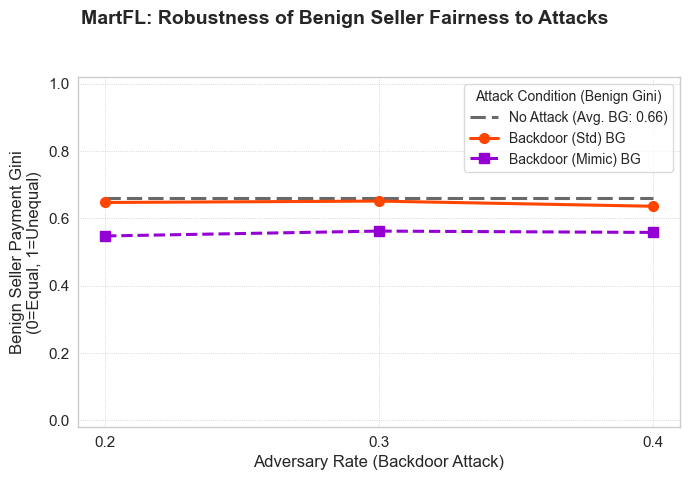

In [70]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.lines import Line2D

# This cell depends on 'summary_df_avg' being loaded and preprocessed in Cell 1.
# It will now use 'AVG_BENIGN_PAYMENT_GINI' from your CSV.

# Define the correct column name from your CSV
ACTUAL_BENIGN_GINI_COLUMN_NAME = 'AVG_BENIGN_PAYMENT_GINI'

if 'summary_df_avg' in locals() and not summary_df_avg.empty:
    plot_data_benign_gini = summary_df_avg.copy()
    current_aggregation_method = "MartFL" # Assuming 'MartFL'

    if ACTUAL_BENIGN_GINI_COLUMN_NAME not in plot_data_benign_gini.columns:
        print(f"Error (Benign Gini Plot): '{ACTUAL_BENIGN_GINI_COLUMN_NAME}' column not found. Cannot create plot.")
    elif plot_data_benign_gini[ACTUAL_BENIGN_GINI_COLUMN_NAME].isna().all():
        print(f"Error (Benign Gini Plot): '{ACTUAL_BENIGN_GINI_COLUMN_NAME}' column contains only NaN values. Cannot create plot.")
    else:
        # Column already preprocessed (numeric, rounded) by preprocess_experiment_data if listed in FLOAT_PRECISIONS
        # Ensure it's numeric if it wasn't in FLOAT_PRECISIONS, though it should be
        plot_data_benign_gini[ACTUAL_BENIGN_GINI_COLUMN_NAME] = pd.to_numeric(
            plot_data_benign_gini[ACTUAL_BENIGN_GINI_COLUMN_NAME], errors='coerce'
        )
        rows_before_dropna_bg = len(plot_data_benign_gini)
        plot_data_benign_gini.dropna(subset=[ACTUAL_BENIGN_GINI_COLUMN_NAME], inplace=True)
        if len(plot_data_benign_gini) < rows_before_dropna_bg:
            print(f"Plot Benign Gini: Dropped {rows_before_dropna_bg - len(plot_data_benign_gini)} rows with NaN {ACTUAL_BENIGN_GINI_COLUMN_NAME} values.")

        # 1. "No Attack" Benign Gini Baseline (Averaged over IS_SYBIL)
        no_attack_data_bg = plot_data_benign_gini[plot_data_benign_gini['ATTACK_METHOD'] == 'No Attack'].copy()
        no_attack_avg_benign_gini = no_attack_data_bg[ACTUAL_BENIGN_GINI_COLUMN_NAME].mean() if not no_attack_data_bg.empty else np.nan

        # 2. "Backdoor Attack" Benign Gini Data, distinguishing IS_SYBIL
        adv_rates_to_plot_on_x = [0.1, 0.2, 0.3, 0.4]
        backdoor_benign_gini_data = plot_data_benign_gini[
            (plot_data_benign_gini['ATTACK_METHOD'] == 'Backdoor') &
            (plot_data_benign_gini['ADV_RATE'].isin(adv_rates_to_plot_on_x))
        ].copy()

        if not backdoor_benign_gini_data.empty:
            backdoor_benign_gini_by_sybil = backdoor_benign_gini_data.groupby(
                ['ADV_RATE', 'IS_SYBIL'], as_index=False
            )[ACTUAL_BENIGN_GINI_COLUMN_NAME].mean().sort_values(by=['IS_SYBIL', 'ADV_RATE'])
            adv_rates_present_in_data = sorted(backdoor_benign_gini_by_sybil['ADV_RATE'].unique())
        else:
            print(f"Warning (Benign Gini Plot): No 'Backdoor' data for Benign Gini for ADV_RATEs {adv_rates_to_plot_on_x}.")
            backdoor_benign_gini_by_sybil = pd.DataFrame()
            adv_rates_present_in_data = []

        # --- Plotting Benign Gini ---
        if not backdoor_benign_gini_by_sybil.empty or pd.notna(no_attack_avg_benign_gini):
            TITLE_FONT_SIZE = 14; AXIS_LABEL_FONT_SIZE = 12; TICK_LABEL_FONT_SIZE = 11
            LEGEND_FONT_SIZE = 10; LINE_WIDTH = 2.2; MARKER_SIZE = 7

            fig, ax = plt.subplots(figsize=(7, 4.8))

            colors = { 'No Attack': 'dimgray', 'Backdoor (Standard)': 'orangered', 'Backdoor (Mimic)': 'darkviolet' }
            linestyles = { 'No Attack': (0, (5, 2)), 'Backdoor (Standard)': '-', 'Backdoor (Mimic)': '--' }
            markers = { 'Backdoor (Standard)': 'o', 'Backdoor (Mimic)': 's' }
            legend_elements_gini = []

            xmin_hline = min(adv_rates_present_in_data) if adv_rates_present_in_data else min(adv_rates_to_plot_on_x)
            xmax_hline = max(adv_rates_present_in_data) if adv_rates_present_in_data else max(adv_rates_to_plot_on_x)

            if pd.notna(no_attack_avg_benign_gini):
                ax.hlines(y=no_attack_avg_benign_gini, xmin=xmin_hline, xmax=xmax_hline,
                          color=colors['No Attack'], linestyle=linestyles['No Attack'], linewidth=LINE_WIDTH)
                legend_elements_gini.append(Line2D([0], [0], color=colors['No Attack'], linestyle=linestyles['No Attack'],
                                                  lw=LINE_WIDTH, label=f'No Attack (Avg. BG: {no_attack_avg_benign_gini:.2f})'))

            if not backdoor_benign_gini_by_sybil.empty:
                data_std = backdoor_benign_gini_by_sybil[backdoor_benign_gini_by_sybil['IS_SYBIL'] == 'False']
                if not data_std.empty:
                    ax.plot(data_std['ADV_RATE'], data_std[ACTUAL_BENIGN_GINI_COLUMN_NAME], # Use actual name
                            color=colors['Backdoor (Standard)'], linestyle=linestyles['Backdoor (Standard)'],
                            marker=markers['Backdoor (Standard)'], linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
                    legend_elements_gini.append(Line2D([0], [0], color=colors['Backdoor (Standard)'], linestyle=linestyles['Backdoor (Standard)'],
                                                      marker=markers['Backdoor (Standard)'], markersize=MARKER_SIZE, lw=LINE_WIDTH,
                                                      label='Backdoor (Std) BG'))

                data_mimic = backdoor_benign_gini_by_sybil[backdoor_benign_gini_by_sybil['IS_SYBIL'] == 'mimic']
                if not data_mimic.empty:
                    ax.plot(data_mimic['ADV_RATE'], data_mimic[ACTUAL_BENIGN_GINI_COLUMN_NAME], # Use actual name
                            color=colors['Backdoor (Mimic)'], linestyle=linestyles['Backdoor (Mimic)'],
                            marker=markers['Backdoor (Mimic)'], linewidth=LINE_WIDTH, markersize=MARKER_SIZE)
                    legend_elements_gini.append(Line2D([0], [0], color=colors['Backdoor (Mimic)'], linestyle=linestyles['Backdoor (Mimic)'],
                                                      marker=markers['Backdoor (Mimic)'], markersize=MARKER_SIZE, lw=LINE_WIDTH,
                                                      label='Backdoor (Mimic) BG'))

            ax.set_xlabel('Adversary Rate (Backdoor Attack)', fontsize=AXIS_LABEL_FONT_SIZE)
            ax.set_ylabel('Benign Seller Payment Gini\n(0=Equal, 1=Unequal)', fontsize=AXIS_LABEL_FONT_SIZE)
            ax.tick_params(axis='both', which='major', labelsize=TICK_LABEL_FONT_SIZE, pad=6)
            ax.set_ylim(-0.02, 1.02)
            
            plot_xticks_bg = adv_rates_present_in_data if adv_rates_present_in_data else adv_rates_to_plot_on_x
            if plot_xticks_bg :
                 ax.set_xticks(ticks=plot_xticks_bg); ax.set_xticklabels(labels=[f'{r:.1f}' for r in plot_xticks_bg])
            
            ax.grid(True, which='major', linestyle=':', linewidth=0.6)

            if legend_elements_gini:
                ax.legend(handles=legend_elements_gini, title='Attack Condition (Benign Gini)', fontsize=LEGEND_FONT_SIZE, loc='best', frameon=True, edgecolor='lightgray')
            fig.suptitle(f'{current_aggregation_method}: Robustness of Benign Seller Fairness to Attacks',
                         fontsize=TITLE_FONT_SIZE, y=0.99, fontweight='bold')
            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()
        else:
            print("Not enough data to plot Benign Gini after filtering for specific conditions.")
else:
    print("DataFrame 'summary_df_avg' is not available for Benign Gini plot (empty or not loaded).")

KeyError: 'NO_ATTACK_DESIGNATED_MALICIOUS_SELECTION_RATE'